# Final notebook

### import libraries

In [1]:
#built in librairies 
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd


# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, State
import dash_leaflet as dl
import dash_leaflet.express as dlx
import dash
from dash_extensions.javascript import assign
from dash.exceptions import PreventUpdate
import matplotlib.patches as patches

# Natural Language Processing Librairies
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re

#Calculating libraries
import scipy as sp

#statistical librairies
import pingouin 

# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle

#time series libraries
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.robust_stat_detection import RobustStatDetector

#from genres import genre_wordsets
import csv
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from utils.genres import additional_wordsets
from pandas_profiling import ProfileReport

import sys
sys.path.append("../")
from os import path

import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# pip libraires
from time import sleep
from random import randint
import time

# Natural Language Processing Librairies
import spacy
from spacy import displacy
import spacy_transformers


# Others
from functools import partial
from ast import literal_eval

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Geopositioning and mapping
import geopandas as gpd 
import geopy 
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError


from nltk import sent_tokenize
from transformers import pipeline
from textblob import TextBlob
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# LDA_LIB
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from wordcloud import WordCloud
import wordcloud
from itertools import chain

/home/bastienll/Anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Our dataset contains different datasets. We have:
- Metadata
- Plots of Movies
- Characters 


# Data wrangling

## Character types

In [2]:
"""read table tvtropes and process the data to get rid of json format
"""
tvtropes = pd.read_table('./data/tvtropes.clusters.txt', header = None)
json_cols = [1]
for col in json_cols:
    tvtropes[col] = tvtropes[col].apply(lambda x: list(json.loads(x).values()))
tvtropes = pd.merge(tvtropes, tvtropes[1].apply(pd.Series), left_index=True, right_index=True)
tvtropes.columns = ["character_type", "drop", "char", "movie", "id", "actor"]
tvtropes = tvtropes.drop(["drop"], axis = 1)
tvtropes.shape

(501, 5)

we observe there is very little character type and this use is therefore difficult

## Metadata

First of all we import the data from their corresponding files. The datasets we will be using are the following :
- metadata : Movie metadata, mainly containing the name, release date and genre of different movies
- ratings : Contains the IMDb rating and votes information for titles of the movies.
- titles : Used with the ratings dataset to correlate ratings with movie names

In [3]:
metadata = pd.read_table('./data/movie.metadata.tsv', header=None)
metadata_copy = pd.read_table('./data/movie.metadata.tsv', header=None)
metadata.columns = ["wiki_id", "freebase_id", "movie_name", "release_date", "box_office", "duration", "language", "country", "genre"]
metadata_copy.columns = ["wiki_id", "freebase_id", "movie_name", "release_date", "box_office", "duration", "language", "country", "genre"]
ratings = pd.read_csv('./data/title.ratings.tsv', sep="\t")
titles = pd.read_csv('./data/title.basics.tsv', sep="\t")


We then need to format a bit the dataset, mainly transforming the release date to the datetime format in order to harmonize data.

In [4]:
# Add the corresponding titles to their rating
titles = pd.merge(titles, ratings, on='tconst')
titles = titles[['primaryTitle', 'originalTitle', 'averageRating', 'startYear']]

# Transform all date related columns to datetime format
titles['Movie_release_year'] = pd.to_datetime(titles['startYear'], errors='coerce').dt.year
metadata['Movie_release_year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year

titles = titles.rename(columns={'primaryTitle': 'movie_name'})

titles = titles.groupby('movie_name').mean()
titles.reset_index(inplace=True)

# merge movies by release year and name


In [5]:
metadata.groupby("country").count().sort_values(['wiki_id'], ascending=False).head(10)

,wiki_id,freebase_id,movie_name,release_date,box_office,duration,language,genre,Movie_release_year
country,,,,,,,,,
"{""/m/09c7w0"": ""United States of America""}",30300,30300,30300,29181,5484,25610,30300,30300,29181
"{""/m/03rk0"": ""India""}",8240,8240,8240,7599,27,3558,8240,8240,7599
{},8154,8154,8154,5228,139,3585,8154,8154,5228
"{""/m/07ssc"": ""United Kingdom""}",5343,5343,5343,4985,177,4379,5343,5343,4985
"{""/m/03_3d"": ""Japan""}",2242,2242,2242,2012,88,1971,2242,2242,2012
"{""/m/0f8l9c"": ""France""}",1853,1853,1853,1724,79,1595,1853,1853,1724
"{""/m/03rjj"": ""Italy""}",1730,1730,1730,1631,13,1232,1730,1730,1631
"{""/m/0d060g"": ""Canada""}",1342,1342,1342,1216,53,1178,1342,1342,1216
"{""/m/0jgd"": ""Argentina""}",1266,1266,1266,1230,8,347,1266,1266,1230


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wiki_id             81741 non-null  int64  
 1   freebase_id         81741 non-null  object 
 2   movie_name          81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office          8401 non-null   float64
 5   duration            61291 non-null  float64
 6   language            81741 non-null  object 
 7   country             81741 non-null  object 
 8   genre               81741 non-null  object 
 9   Movie_release_year  74838 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 6.2+ MB


Here are our observations:
- Box Office contains mainly null values, so we drop the column.
- The type of the release_date is an object, we will transform it into a datetime to make sampling easier.

In [7]:
metadata.drop(columns="box_office", inplace=True)
metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')


We note that language, country, genre are JSONs. Therefore, we nede to transform them into a list

In [8]:
json_cols = ["language", "country", "genre"]
for col in json_cols:
    metadata[col] = metadata[col].apply(lambda x: list(json.loads(x).values()))

In [9]:
metadata.head()

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre,Movie_release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,106.0,[German Language],[Germany],[Drama],1983.0


We are aware that the columns can contain list with one value at a time. For simplicity of cleaning, we leave it llike that for the moment.

In [10]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [11]:
genres =pd.Series(flatten_list(list(metadata.genre)))
n_genres = len(set(genres))
print("Number of genres: {} ".format(n_genres))

Number of genres: 363 


We have 363 genres. Some of them are quite specific : Homoeroticism, silhouette animation and other are more general.
In order to have a deeper analysis for the genres, we need to link every genre into a metagenre. 

Therefore, we have created a mapping to the 363 genres to broader meta-genres.

### Metagenre classification
### Natural Language Processing (NLP): Stemming ###
The first step is to create some Natural Language Processing and cleaning functions. 

The first function allows us to stem a string, by doing this we can classify all similar words with the same *root*. A lot of the genres in the dataset are variations of the same word and genre. By extracting the body of the word, these variations are considered the same and will be classified together. Some examples of this principle can be seen in the following table, where two similar genres are put together :

| Genre 1 | Genre 2 | Root    | Metagenre |
|-------|-------|-------|-------|
| Biography | Biographical   | Biograph | History
| Romantic | Romantical | Rom | Romance

We decided to use one of the most aggressive stemmers - the Lancaster Stemmer - as it gave the best results compared to other stemmers (Porter stemmer or Snowball stemmer) that often had classification problems. Lemmatizers were also considered, however we also found errors in classification.

| Algorithm | Genre 1 | Root 1 | Genre 2 | Root 2 | Metagenre |
|-------|-------|-------|-------|-------|-------|
| Lancaster Stemmer | Historical   | Hist | History | Hist | History
| Porter Stemmer | Historical   | Histor | History | Histori | History
| Snowball Stemmer | Historical   | Histor | History | Histori | History
| WordNet Lemmatizer | Historical   | Historical | History | History | History

As we can see the Lancaster stemmer gives us the desired result.

In [12]:
def stem_string(x:str) -> list:
    """Returns the stem of every word in the input

    Args:
        x (str): Contains the input to be stemmed

    Returns:
        list: a list of the words stemmed
    """
    
    # Create a stemmer, the Lancaster Stemmer is used here
    stemmer = LancasterStemmer()

    # Tokenize the string --> separate words in a list, separating punctuation as well
    words = word_tokenize(x)

    # Stem every word in the tokenized list
    stemmed_words = [stemmer.stem(word) for word in words]

    # Return a list of Stemmed words
    return stemmed_words


### Natural Language Processing (NLP): String Cleaning ###

The second part of our genre processing is cleaning the data. Basic NLP cleaning is used : lower characters only, use only alphabetic characters and dash, remove double spaces. 

We however decided to formalize two genres : black-and-white and science-fiction. Making sure that there two genres are written with a dash ('-') this allows us to later compare the word as a whole.

In [13]:
def clean_string(str:str) ->str:
    """
    This function cleans the input string using basic NLP and Regex 

    Args:
        str (string): input string 

    Returns:
        string: a cleaned formalized string
    """
    # Make all characters lower caps
    clean_s = str.lower()

    # Transforms all spaces to dashes if they are followed by the word "white". Used to formalize black-and-white
    clean_s = re.sub(r'-(?!.*(white))', ' ', clean_s)

    # Transforms all spaces to dashes if they are followed by the word "fi" and preceded by "sci",
    #  or followed by the word "fiction" and preceded by "science". Used to formalize "sci-fi" and "science-fiction"

    clean_s = re.sub(r'((?<=sci) (?=fi))|((?<=science) (?=fiction))', '-', clean_s)

    # remove everything except alphabets and dashes
    clean_s = re.sub("[^a-zA-Z-]", " ", clean_s) 

    # remove double whitespaces 
    clean_s = ' '.join(clean_s.split()) 
    return clean_s


In [14]:
def clean(var:object):
    """
    This functions detects the input object structure and cleans all strings present.
    Can be called recursively if multiple dimensions exist in the structure
    
    Args:
        var (object): input string, list or dictionary

    Returns:
        object: a cleaned formalized string, list or dictionary
    """
    # Create output variable
    out = ''

    # Detect if input is a list
    if type(var) == list:
        out = var.copy()
        # Clean each string in list
        for i,s in enumerate(var):
            out[i] = clean_string(s)
    else :
        # Detect if input is a dictionary
        if type(var) == dict:
            out = var.copy()
            # Clean each key and value
            for key, value in var.items():
                out[clean_string(key)] = clean(value)
        else:
            # Detect if input is a string
            if type(var) == str:
                # Clean string
                out = clean_string(var)
            
            # Raise an exception if input is not a string, list or dictionary
            else:
                raise Exception("Wrong input type for cleaning ! ")

    return out

### Metagenre and subgenre definition ###


In order to create a dictionary with every Metagengre and it's corresponding subgenres, we decided to extract data from the web, specifically the genre list of *studio blinder*. The following website was chosen as it had a good HTML structure and rich information about movie genres and subgenres, as well as being a trusty platform for movie production.

In [15]:
# Website URL
URL = 'https://www.studiobinder.com/blog/movie-genres-list/'

# Make the request for the website
r = requests.get(URL)


In [16]:
# Initialise BeautifulSoup for easy HTML analysis
soup = BeautifulSoup(r.text, 'html.parser')

# Extract the HTML wrappers for the major genres
metagenre_wrappers = soup.find_all('div', {"data-css": ["tve-u-16d41491117", "tve-u-16d41ed6dc1", "tve-u-17317362207"]})

# Print the number of metagenres in the website
print('Total number of items: {0}'.format(len(metagenre_wrappers)))

genres = dict([])

# Loop through all the metagenres wrappers, except the last one as it contains other genres that we decided not to add
for p in metagenre_wrappers[:-1]:    
    # Extract all subgenres
    sub_g = p.find_all('h5')
    # Extract metagenre name
    major_genres = p.find_all('h3')

    for g in major_genres :
        # (extract only first word since all metagenres strings are followed by the unwanted word "genre"
        m_genre = clean(g.string.rsplit(' ', 1)[0])
        # For each major genre, create a disctionary entry with the genre keyword 
        genres[m_genre] = []

    for s in sub_g :
        # Add each subgenre to the corresponding metagenre entry
        genres[m_genre].append(clean(str(s.string)))

# Print the results
print("The extracted metagenres and subgenres are : ")
[print(key, ': ', value) for key, value in genres.items()]

Total number of items: 14
The extracted metagenres and subgenres are : 
action :  ['heroic bloodshed', 'military action', 'espionage', 'wuxia action', 'disaster', 'adventure', 'superhero']
animation :  ['traditional', 'stop motion', 'claymation', 'cutout', 'computer generated imagery', 'puppetry', 'live action']
comedy :  ['action comedy', 'dark comedy black comedy', 'romantic comedy', 'buddy comedy', 'road comedy', 'slapstick comedy', 'parody', 'spoof', 'satire', 'sitcom', 'sketch comedy', 'mockumentary', 'prank']
crime :  ['caper', 'heist', 'gangster', 'cop police', 'detective', 'courtroom', 'procedural']
drama :  ['melodrama', 'teen drama', 'philosophical drama', 'medical drama', 'legal drama', 'political drama', 'anthropological drama', 'religious drama', 'docudrama']
experimental :  ['surrealist', 'absurdist']
fantasy :  ['contemporary fantasy', 'urban fantasy', 'dark fantasy', 'high fantasy', 'myth']
historical :  ['historical event', 'biography', 'historical epic', 'historical f

[None, None, None, None, None, None, None, None, None, None, None, None, None]

### Genre cleaning ###

A lot of genres present in the dictionaries are confusing and will cause wrong classification. when compared later on with the dataset genres. Think for example of the genre "*romance drama*" under *romance* or "*epic western*" under *western*. Since we compare genres word by word, we would only like to have the corresponding keyword so "romance" and "western", since drama will be present either way in the drama metagenre and the word "epic" is applicable to multiple genres not only western. This rule is true for most subgenres : if the metagenre word is present, then the other word is a vague genre applicable to the other metagenres as well (Epic, Urban, etc.) and must be removed.

In [17]:
def clean_confusing_genres(all_genres:dict) ->None:
    """
    This functions removes all the confusing genres from the dictionary.
    
    Args:
        all_genres (dict): input dictionary

    """
    # Create a list with all the stemmed metagenres
    key_list = list(all_genres.keys())
    key_list = [stem_string(key) for key in key_list]

    # Iterate through all the metagenres and their subgenres
    for major_genres, sub_genres in all_genres.items():
        
        stemmed_major_genre = stem_string(major_genres)
        tmp = sub_genres.copy()

        for s_g in tmp :
            
            if (stemmed_major_genre[0] in s_g) and len(s_g) >= 2 :
                sub_genres.remove(s_g)

            # Revome the word "film" from every subgenre.
            if "film" in s_g :
                s_g.remove("film")
            
            # Revome the word "fiction" from every subgenre.
            if "fict" in s_g :
                s_g.remove("fict")

            #  Revome the subgenre "military" from the "science-fiction" metagenre.
            if "milit" in s_g and stemmed_major_genre[0] == "science-fiction":
                s_g.remove("milit")
        
        # Add as a subgenre the corresponding metagenre
        all_genres[major_genres].append(stemmed_major_genre) 
        
        # Clean the genre dictionary, mainly removing empty lists   
        all_genres[major_genres] = [x for x in sub_genres if x]

Even if the studio binder website contains multiple metagenres, we would like to add our own genres and subgenres in order to have better classification as well as other inicators for our analysis such as "propaganda" and "diversity" metagenres. We therefore import our own genre dictionary.

In [18]:
from utils.genres import additional_wordsets

In [19]:
def mergeDictionary(dict_1:dict, dict_2:dict) -> dict:
    """
    This functions removes all the confusing genres from the dictionary.
    
    Args:
        dict_1 (dict): first input dictionary to merge
        dict_2 (dict): second input dictionary to merge

    Returns:
        dict: merged dictionary

    """
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def stem_dictionary(dict:dict) -> None:
    """
    This functions stems all values in a dictionary.
    
    Args:
        dict (dict): input dictionary to stem
    """
    # Stems every string in the dictionary values
    for key, values in dict.items():
        dict[key] = [stem_string(v) for v in values]

In [20]:
# Create final genre dictionary with web and local genres
genre_map = mergeDictionary(genres, clean(additional_wordsets))
stem_dictionary(genre_map)
clean_confusing_genres(genre_map)

# Display final Dictionary used for classification
[print(key, ': ',value) for key, value in genre_map.items()];

action :  [['swashbuckl'], ['comb'], ['mart'], ['box'], ['sword'], ['hero', 'bloodsh'], ['esp'], ['disast'], ['adv'], ['superhero'], ['act']]
animation :  [['cartoon'], ['tradit'], ['stop', 'mot'], ['claym'], ['cutout'], ['comput', 'gen', 'imagery'], ['puppetry'], ['liv', 'act'], ['anim']]
comedy :  [['slapstick'], ['tragicomedy'], ['ston'], ['parody'], ['spoof'], ['satir'], ['sitcom'], ['mocku'], ['prank'], ['comedy']]
crime :  [['spy'], ['crimin'], ['prison'], ['slash'], ['whodunit'], ['crimin'], ['cap'], ['heist'], ['gangst'], ['cop', 'pol'], ['detect'], ['courtroom'], ['proc'], ['crim']]
drama :  [['tragicomedy'], ['american'], ['tragedy'], ['melodram'], ['docudram'], ['dram']]
experimental :  [['indy'], ['short'], ['art'], ['sur'], ['absurd'], ['expery']]
fantasy :  [['supern'], ['myth'], ['fantasy']]
historical :  [['hist'], ['hist'], ['biop'], ['biograph'], ['biograph'], ['period', 'piec'], ['hist']]
horror :  [['haunt'], ['ghost'], ['monst'], ['werewolf'], ['vampir'], ['occult'

In [21]:
def extract_genres(df_genres: list) -> list:
    """ 
    finds all the metagenres from the movie genre list, referring to the the genre_map 

    Args:
        df_genres (list): list of subgenres

    Returns:
        list: list of metagenres
    """
    genre_list = []
    input_genres = df_genres.copy()

    # Clean and concatenate all genres in the input
    merged_stem_strings = [stem_string(clean(g)) for g in input_genres]

    # For each major genre and subgenre in the genre map, check if they are in the input
    for major_genres, sub_genres in genre_map.items(): 
        for s_g in sub_genres :
            for item in merged_stem_strings :
                if s_g[0] in item :
                    genre_list.append(major_genres)

    # If no metagenre was found, classify movie as "other"
    if len(genre_list) == 0:
        genre_list.append("Other")

    # Remove metagenre duplicates
    genre_list = list(set(genre_list))

    return genre_list

### Metagenres

In [22]:
metadata["metagenre"] = metadata["genre"].apply(extract_genres)

We will present an analysis for evolution of metagenres throughout the time in the Analysis Section.

In [23]:
metadata.head(5)

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre,Movie_release_year,metagenre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,"[thriller, action, horror, science-fiction, fa..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000.0,"[drama, crime, thriller, historical]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0,"[drama, crime]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,"[thriller, erotic]"
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,106.0,[German Language],[Germany],[Drama],1983.0,[drama]


see file metadata_report.html for more details 

## Movie Plots

In [24]:
# read plots
plots = []
with open("data/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

movie_id = []
plot = []


42303it [00:00, 61478.80it/s]


In [25]:
# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])


100%|██████████| 42303/42303 [00:00<00:00, 1863445.00it/s]


In [26]:
# create dataframe
plots = pd.DataFrame({'wiki_id': movie_id, 'plot': plot})
plots.wiki_id = plots.wiki_id.astype(int)

In [27]:
def clean_text(text):
    # remove a string like {{plot}}
    text = re.sub("\s*{{\w*}}\s*", "", text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    text = text.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0', ' ') #get rid of problem chars
    
    text = ' '.join(text.split())
    
    return text

plots['plot'] = plots['plot'].apply(clean_text)


<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_153158/2373640595.py:3: DeprecationWarning: invalid escape sequence \s
  text = re.sub("\s*{{\w*}}\s*", "", text)


In [28]:
plots.head(5)

,wiki_id,plot
0,23890098,"shlykov, a hard-working taxi driver and lyosha..."
1,31186339,the nation of panem consists of a wealthy capi...
2,20663735,poovalli induchoodan is sentenced for six year...
3,2231378,"the lemon drop kid , a new york city swindler,..."
4,595909,seventh-day adventist church pastor michael ch...


The plots dataset contains a little over 42000 summaries of movies, each linked to a movie through an ID

### Sentiment analysis

We load the data from plot_sentiment.csv, it corresponds to the sentiment analysis of the movie plots and the sentiment is in 3+1 category.
We have the negative neutral and positive sentiment that are quantified between 0 and 1 with negative = 0 being not negative at all and negative = 1 being very negative.
There is also a compound score that give a one number analysis between -1 (very negative) and 1 (very positive).

This dataset is made in the notebook  ***Plot_analysis.ipynb***

In [29]:
sentiment = pd.read_csv('./data/plot_sentiment.csv')
sentiment.drop('Unnamed: 0', axis=1, inplace=True)
sentiment.head(5)

,movie_name,wiki_id,neg,neu,pos,compound
0,Taxi Blues,23890098,0.083,0.832,0.084,0.0083
1,The Hunger Games,31186339,0.132,0.791,0.077,-0.9941
2,Narasimham,20663735,0.178,0.704,0.119,-0.9867
3,The Lemon Drop Kid,2231378,0.111,0.786,0.103,-0.6127
4,A Cry in the Dark,595909,0.108,0.825,0.067,-0.9538


In [30]:
df_summaries = pd.merge(plots, sentiment, on='wiki_id', how ='inner').drop(['neg', 'neu', 'pos', 'compound'], axis=1)

## Characters

In [31]:
characters = pd.read_csv("data/character.metadata.tsv", sep='\t', header=None)


In [32]:
characters.columns = ["wiki_movie_id", "freebase_movie_id", "release_date", "character_name", "date_birth", "gender",
                      "height", "ethnicity", "act_name", "act_age",
                      "freebase_char_actor_id", "freebase_char_id", "freebase_actor_id"]

We observe that the release_date and date_birth are dates and we therefore transform them to datetime to be able to handle them more simply

In [33]:
characters.release_date = pd.to_datetime(characters.release_date, errors='coerce')
characters.date_birth = pd.to_datetime(characters.date_birth , errors='coerce')

In [34]:
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We see in the first lines a few Nan and therefore it is worth to verify how much data is missing

In [35]:
characters.isna().sum(axis=0)

wiki_movie_id                  0
freebase_movie_id              0
release_date               10010
character_name            257875
date_birth                106168
gender                     45609
height                    295845
ethnicity                 344611
act_name                    1228
act_age                   158113
freebase_char_actor_id         0
freebase_char_id          257865
freebase_actor_id            815
dtype: int64

In [36]:
print('we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent {0}  as there many character in most films and we have here many films.'.format(characters.ethnicity.isna().sum()/characters.size))

we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent 0.05882041689474639  as there many character in most films and we have here many films.


In [37]:
#profile = ProfileReport(characters, title ="Pandas Profiling Report")
#profile.to_file("character_report.html")

see file character_report.html

### Load character etnicities

We load the ethnicities that were queried from wikidata in the notebook ***sql.ipynb***

In [38]:
etn = pd.read_csv('data/etnicities.csv')
etn.drop('Unnamed: 0', axis=1, inplace=True)
etn.columns = ['ethnicity', 'etn_label']
etn.replace(-1, np.nan, inplace=True)
etn = pd.merge(etn, characters, on='ethnicity', how='inner').drop('ethnicity', axis=1)

In [39]:
todrop = ['freebase_movie_id', 'date_birth', 'gender', 'height', 'act_name', 'act_age', 'freebase_char_actor_id', 'freebase_char_id', 'freebase_actor_id', 'wiki_movie_id', 'character_name']

etn.drop(todrop, axis=1, inplace=True)
dummies = pd.get_dummies(etn.etn_label, dummy_na=True)
etn = etn.join(dummies).groupby('release_date').sum()
etn['total'] = etn.sum(axis=1)

In [40]:
etn.sample(5)

,-1,Aboriginal Australians,Acadians,Acehnese people,Afghans in India,African Americans,African people,Afrikaners,Afro Trinidadians and Tobagonians,Afro-Cuban,...,history of the Jews in the African diaspora,indigenous peoples of the Americas,multiracial people,names of the Greeks,peoples of the Caucasus,rajput,white Americans,white people,NaN,total
release_date,,,,,,,,,,,,,,,,,,,,,
1989-01-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1972-08-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2000-03-15,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5
1984-12-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1943-02-19,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## Historical events

In [41]:
event = pd.read_csv('./data/events.txt', header=None)
event.rename(columns={0: 'event', 1: 'begin_date', 2: 'end_or_popularisation_date', 3: 'type_of_event'}, inplace = True)
event['begin_date'] = pd.to_datetime(event['begin_date'], errors='coerce', format='%Y')
event['end_or_popularisation_date'] = pd.to_datetime(event['end_or_popularisation_date'], errors = 'coerce', format = '%Y')
event.head(5)

,event,begin_date,end_or_popularisation_date,type_of_event
0,WW1,1914-01-01,1918-01-01,war
1,russian communist revolution,1917-01-01,1917-01-01,war
2,economic depression,1929-01-01,1929-01-01,economic
3,rise of dictatorships,1920-01-01,1940-01-01,politic
4,WW2,1939-01-01,1945-01-01,war


# Analysis

## Genre, ratings and war 

### evolution of genre during the years

##### create dummy variables to work with genres

In [42]:
metadata.columns

Index(['wiki_id', 'freebase_id', 'movie_name', 'release_date', 'duration',
       'language', 'country', 'genre', 'Movie_release_year', 'metagenre'],
      dtype='object')

In [43]:
dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level =0)
metadata = metadata.join(dummies_genres)

In [44]:
sentiment = pd.merge(sentiment, metadata, on = 'wiki_id', how = 'inner')
#create 'bag of genres' to have a more visual output at the end
sentiment['action_type'] = 1/4*(sentiment.action.fillna(0) + sentiment.thriller.fillna(0) + sentiment.western.fillna(0) + sentiment.war.fillna(0))
sentiment['romance_type'] = (sentiment.romance.fillna(0) + sentiment.drama.fillna(0))*1/2
sentiment['comedy_type'] = (sentiment.comedy.fillna(0) + sentiment.family.fillna(0) + sentiment.animation.fillna(0) + sentiment.musical.fillna(0))*1/4
sentiment['horror_type'] = (sentiment.horror.fillna(0) + sentiment.crime.fillna(0))*1/2
sentiment['experimental_type'] = (sentiment.experimental.fillna(0) + sentiment.documentary.fillna(0) + sentiment['black and white'].fillna(0) + sentiment.silent.fillna(0))*1/4
sentiment['fantasy_type'] = (sentiment.fantasy.fillna(0) + sentiment['science-fiction'].fillna(0))*1/2
sentiment['other_type'] = (sentiment.Other.fillna(0) + sentiment.erotic.fillna(0) + sentiment.propaganda.fillna(0)+ sentiment.religious.fillna(0))*1/4
#we create dummy variables for the metagenre this way each sentiment is projected to the genre of the film
sentiment = sentiment.groupby('release_date').mean()
cols_to_drop = ["Movie_release_year", "duration"]
sent = sentiment.copy().drop(columns=cols_to_drop).replace(0,np.nan)
sentiment_dummies = sent.multiply(sent['compound'], axis ="index").groupby('release_date').sum()
sentiment_dummies = sentiment_dummies/sent[sentiment_dummies.columns]
sentiment_dummies.drop(columns=['compound', 'pos', 'neg', 'neu'], inplace = True)
sentiment_dummies = sentiment_dummies.fillna(0)
sentiment_dummies.head(5)

,wiki_id,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,...,thriller,war,western,action_type,romance_type,comedy_type,horror_type,experimental_type,fantasy_type,other_type
release_date,,,,,,,,,,,,,,,,,,,,,
1893-01-01,-0.585900,0.0,0.0,0.000000,-0.585900,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.585900,0.0,0.0
1894-10-09,0.476700,0.0,0.0,0.000000,0.476700,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.476700,0.0,0.0
1894-11-17,0.802000,0.0,0.0,0.000000,0.802000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.802000,0.0,0.0
1895-01-01,0.241687,0.0,0.0,0.241687,0.241687,0.241687,0.0,0.0,0.241687,0.0,...,0.0,0.0,0.0,0.0,0.0,0.241687,0.0,0.241687,0.0,0.0
1895-06-12,-0.051600,0.0,0.0,0.000000,-0.051600,0.000000,0.0,0.0,-0.051600,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.051600,0.0,0.0


In [45]:
#we create dummy variables for the metagenre this way each rating is projected to the genre of the film
#it is a little bit more complex for the rating as we need to take the mean rather than the sum being mindlful of the nan values or 0 values
ratings = pd.merge(metadata, titles, on=['movie_name', 'Movie_release_year']).drop(['Movie_release_year'], axis=1)
ratings = ratings.groupby('release_date').mean()
cols_to_drop = ["duration"]
ratings = ratings.copy().drop(columns=cols_to_drop).replace(0, np.nan)
rating_per_genre = ratings.multiply(ratings['averageRating'], axis ="index").groupby('release_date').sum()
rating_per_genre = rating_per_genre/ratings[rating_per_genre.columns]
rating_per_genre.fillna(0, inplace=True)
rating_per_genre['mean_tot'] = rating_per_genre.mean(axis=1)

In [46]:
cols_to_drop = ["movie_name", "duration", "language", "country", "genre", "metagenre", "wiki_id", "freebase_id", "Movie_release_year"]
"""we drop ratings but can get them from here for next milestone when analysing them"""
genre_per_date = metadata.copy().drop(columns=cols_to_drop).set_index("release_date")
genre_per_date = genre_per_date.groupby("release_date").sum()

In [47]:
rating_per_genre.sample(5)

,wiki_id,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,...,propaganda,religious,romance,science-fiction,silent,thriller,war,western,averageRating,mean_tot
release_date,,,,,,,,,,,,,,,,,,,,,
2012-06-12,7.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,1.346154
1958-10-09,5.9,0.0,5.9,0.0,5.9,5.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,0.0,0.0,5.9,1.588462
1987-02-12,6.7,0.0,0.0,0.0,0.0,6.7,0.0,0.0,0.0,6.7,...,0.0,0.0,6.7,0.0,0.0,0.0,0.0,0.0,6.7,1.288462
1931-11-27,7.7,0.0,0.0,0.0,0.0,7.7,0.0,0.0,0.0,0.0,...,0.0,0.0,7.7,0.0,0.0,0.0,0.0,0.0,7.7,1.184615
1977-10-27,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.076923


We use dummy variables to deal with genre individually per dates. There might be cases where there is dummy varibles > 1 because film of same genre might have been released on the same day. 

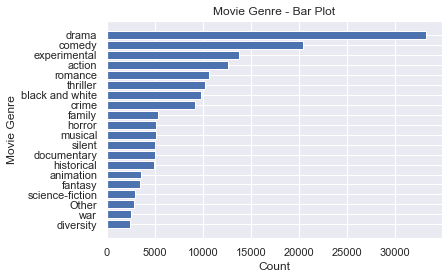

In [48]:
fig, ax = plt.subplots()
n_top_genres = 20 
sorted_genres = genre_per_date.sum(axis=0).sort_values(ascending =False)[:n_top_genres]

ax.barh(sorted_genres.index, sorted_genres.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_ylabel('Movie Genre')
ax.set_title('Movie Genre - Bar Plot')

plt.show()


We can note that genre, comedy and experimental are part of the top three genres. But what about their evolution throughout time?

In [49]:
# sample per period
window = "5Y"

# chose agg funct from aggfunct = [np.sum,np.cumsum]
cumfunc = None

# normalize every period (sum of the row = 1)
normalize = True

# study the pct_change
pct_change_bool = True


In [50]:
def plot_line(df):
    """function to create interactive plots using plotly_express

    Args:
        df (pd.dataframe): a dataframe having a datetime as index
    """
    fig = px.line(df)

    period = [1, 3, 5, 10, 20, 30, 50, 100]
    # Create the financial buttons
    fin_buttons = [{'count': y, 'label': str(y) + "YTD", 'step': "year", 'stepmode': "todate"} for y in period]

    # Create the date range buttons & show the plot
    fig.update_layout({'xaxis': {'rangeselector': {'buttons': fin_buttons}}})
    fig.show()

In [51]:
def genre_per_period(window:str,normalize:bool,pct_change_bool:bool,cumfunc =None):
    """
        genre per period resamples on a certain time windows, and transforms the data to either normalize,
        to mesure the change compared to previous year or to get the cumulative distribution
    Args:
        window (str): the time window we wish to sample the data
        normalize (bool): normalization or not
        pct_change_bool (bool): outputs the percentage of change of the data 
        cumfunc (_type_, optional): cumulative function or not. Defaults to None.

    Returns:
        DataFrame: the result is a newly sampled dataframe that has or not gone through the transformation functions.
    """
    res = genre_per_date.resample(window).sum()
    if not cumfunc ==None:
        res = res.apply(cumfunc)
    
    if normalize:
        res = res.div(res.sum(axis =1), axis =0)

    if pct_change_bool:
        res = res.pct_change().fillna(0)
    return res


In [52]:
df = genre_per_period(window=window, cumfunc=cumfunc, normalize=normalize, pct_change_bool=pct_change_bool)

In [53]:
df["max"] = df.max(axis =1)
df["name_max"] = df.idxmax(axis =1)
df.replace([np.inf, -np.inf], 0, inplace =True)
df.sort_values(by ="max", ascending =False).head(5)


,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,propaganda,religious,romance,science-fiction,silent,thriller,war,western,max,name_max
release_date,,,,,,,,,,,,,,,,,,,,,
1933-12-31,2.877527,0.199959,2.733915,0.121373,0.576444,1.719305,0.723345,0.477153,0.225029,0.723345,...,1.010570,-0.138327,0.684835,0.723345,-0.876589,3.595588,0.215179,0.038426,22.552387,musical
1923-12-31,-0.171902,1.515459,0.610190,-0.114206,-0.336805,1.231753,2.450408,0.207643,0.094183,0.380163,...,-1.000000,1.760326,1.015969,1.760326,0.065117,1.346278,-0.145613,1.157343,10.041306,family
1943-12-31,1.447757,0.095627,-0.179953,0.036423,-0.140487,-0.064129,-0.091877,1.565050,-0.079559,1.118954,...,6.189308,0.059477,-0.236191,0.243734,-0.911710,0.115925,2.526752,-0.001354,6.189308,propaganda
2018-12-31,2.262735,1.192114,0.987836,-1.000000,-0.411217,-0.497878,-1.000000,-1.000000,-0.528351,-1.000000,...,0.000000,-1.000000,0.373478,5.286734,-1.000000,-0.161314,-1.000000,-1.000000,5.286734,science-fiction
1963-12-31,0.265257,-0.090235,-0.218572,-0.126998,0.090818,-0.005244,1.507083,0.099452,0.099880,4.909553,...,0.074464,0.633186,-0.069362,-0.124832,2.223392,-0.070628,0.087895,-0.423932,4.909553,erotic


We here have a dataframe (df) that represents the percentage evolution of the normalized data per genre sampled every 5 years. Under we have an interactive visualisation of this.

In [54]:
plot_line(genre_per_period(window =window, cumfunc =cumfunc, normalize =normalize, pct_change_bool =pct_change_bool))

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [55]:
def two_trends(event,nb, genre,window,deg):
    """this is a helper function to help us build some plots with different trends before and after the event

    Args:
        event (dataframe): event is the event dataframe 
        nb (int): this is the number of the event
        genre (str): this is the genre of interest for the plot
        window (int): this is the window of time we want to look at before and after the event
        deg (int): this is the degree of the polynomial we want to fit
    """
    begin = event.iloc[nb, :].begin_date - relativedelta(years=window+1)
    end = event.iloc[nb, :].begin_date + relativedelta(years=window)
    temp1 = genre_per_date[begin: event.iloc[nb, :].begin_date].resample("2Y").sum()
    temp1['begin'] = '1'
    temp2 = genre_per_date[event.iloc[nb, :].begin_date: end].resample("2Y").sum()
    temp2['begin'] = '0'
    res = pd.concat([temp1, temp2])
    res['time'] = res.index.year
    sns.lmplot(data=res, x='time', y=genre, hue="begin", order=deg)

### Impact of Wars

In [56]:
metagenres = pd.Series(flatten_list(list(metadata.metagenre)))
n_metagenres = len(set(metagenres))
print("Number of genres: {} ".format(n_metagenres))
print(set(metagenres))

Number of genres: 24 
{'science-fiction', 'fantasy', 'experimental', 'diversity', 'family', 'thriller', 'romance', 'action', 'war', 'religious', 'black and white', 'propaganda', 'crime', 'animation', 'documentary', 'silent', 'musical', 'comedy', 'historical', 'drama', 'Other', 'horror', 'erotic', 'western'}


Do violence make people want to watch violence? 

In [57]:
genre_per_date.head(5)

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1889-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1890-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1891-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1892-10-28,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [58]:
#we choose to only show the war movies but this can be changed to any other genre by simply changing it in the code below
fig = px.line(genre_per_date.war.resample("Y").sum().interpolate(), labels={'value': 'number of movie per year'}, title ='war movies during the past centurywith a focus on WW2 period')
fig.add_vrect(x0=pd.to_datetime(1946, format ="%Y"), x1=pd.to_datetime(1939, format ="%Y"), 
              annotation_text ="WW2")
fig.update_xaxes(
    rangeslider_visible =True,
    rangeselector =dict(
        buttons =list([
            dict(count =1, label ="1m", step ="month", stepmode ="backward"),
            dict(count =6, label ="6m", step ="month", stepmode ="backward"),
            dict(count =1, label ="1y", step ="year", stepmode ="backward"),
            dict(count =5, label ="5y", step ="year", stepmode ="backward"),
            dict(count =20, label ="20y", step ="year", stepmode ="backward"),
            dict(step ="all")
        ])
    )
)
fig.show()

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [59]:
fig = px.line(rating_per_genre.resample("3Y").mean().war, labels={'value': 'number of movie per year'}, title = 'comedy movies during the past centurywith a focus on WW2 period')
fig.add_vrect(x0=pd.to_datetime(1946, format ="%Y"), x1=pd.to_datetime(1939, format ="%Y"), 
              annotation_text ="WW2")
fig.update_xaxes(
    rangeslider_visible =True,
    rangeselector =dict(
        buttons =list([
            dict(count =1, label ="1m", step ="month", stepmode ="backward"),
            dict(count =6, label ="6m", step ="month", stepmode ="backward"),
            dict(count =1, label ="1y", step ="year", stepmode ="backward"),
            dict(count =5, label ="5y", step ="year", stepmode ="backward"),
            dict(count =20, label ="20y", step ="year", stepmode ="backward"),
            dict(step ="all")
   ])
    )
)

fig.show()

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [60]:
#transform data to make a boxplot 
y_event = 1945
window_y = 5
df_test = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
df_test.columns = ["Before", "After", "Drop"]
df_test.fillna(0, inplace =True)
df_test.drop(columns ="Drop", inplace =True)
df_test.head()

,Before,After
Other,23.0,49.0
action,79.0,333.0
animation,10.0,146.0
black and white,205.0,860.0
comedy,171.0,663.0


In [61]:
df_modif = df_test.stack().reset_index().rename(columns={"level_0": "genre", "level_1": "Before or after", 0: "Value"})
df_modif.head()

,genre,Before or after,Value
0,Other,Before,23.0
1,Other,After,49.0
2,action,Before,79.0
3,action,After,333.0
4,animation,Before,10.0


Text(0.5, 1.0, 'boxplot of genre before and after the second world war')

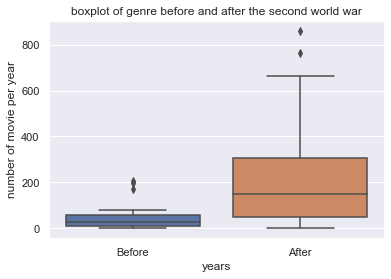

In [62]:
sns.boxplot(data =df_modif, x ='Before or after', y ='Value')
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('boxplot of genre before and after the second world war')


Text(0.5, 1.0, 'histogramm of genre before and after the second world war')

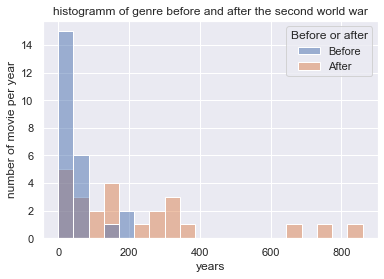

In [63]:
sns.histplot(data =df_modif, hue ='Before or after', x ='Value', bins =20)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('histogramm of genre before and after the second world war')

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Text(30.734520138888897, 0.5, 'number of movie per year')

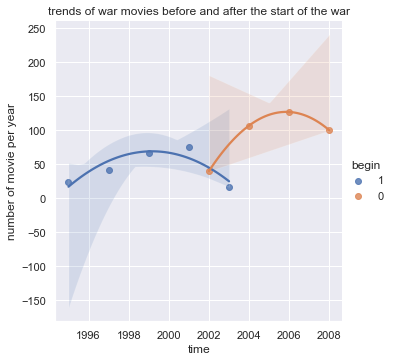

In [64]:
two_trends(event, 23, "war", 6, 2)
plt.title('trends of war movies before and after the start of the war')
plt.ylabel('number of movie per year')

In [65]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T

In [66]:
df_test = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T

In [67]:
pingouin.ttest(x = df_test.iloc[:, 0], y = df_test.iloc[:, 1], paired =True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.838249,23,two-sided,0.00007,"[-253.63, -101.7]",1.026187,374.298,0.997802


we observe a low p value, and we can therefore say that the distributions are not generated from the same process

Text(0.5, 1.0, 'war movies during the last century')

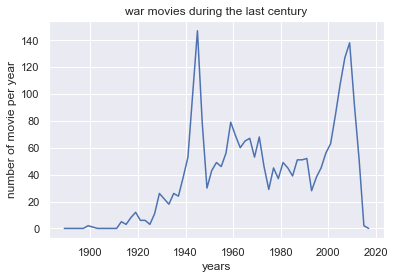

In [68]:
plt.plot(genre_per_date.resample("2Y").sum().war)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('war movies during the last century')

We can observe that there is a clear impact of the war upon the production of war movies and in a slghtly less important way upon comedies. This proves that there is a strong link between movie production and historical event.

In the next milestone we will try to further explore this link by using other metadata such as the popularity of films (imdb ratings), sentiment analysis (e.g. are movies darker or a lighter atmosphere?). Moreover a major historical event is the cold war, and we can explore the difference in impact of this war compared to others knowing that there was no direct fight but a very hight tension.

### Impact of technological advances on cinema

we are going to observe how the apparition of color films and sound in cinema impacted this industry.

In [69]:
fig = px.line(genre_per_date.resample("2Y").sum()['black and white'], labels ={'value': 'number of movie per year'}, title = 'Black and white cinema during the last century')
fig.add_vline(x = pd.to_datetime(1932, format ="%Y"))

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [70]:
y_event = 1932

In [71]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
pingouin.ttest( x = df.iloc[:, 0], y = df.iloc[:, 1], paired = True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.675785,23,two-sided,0.001254,"[-236.37, -66.13]",0.85415,28.774,0.979531


we observe a low p value, and we can therefore say that the distributions are not generated from the same process

In [72]:
df.columns = ["Before", "After", "Drop"]
df.fillna(0, inplace = True)
df.drop(columns = "Drop", inplace = True)
df = df.stack().reset_index().rename(columns = {"level_0": "genre", "level_1": "Before or after", 0: "Value"})


Text(0.5, 1.0, 'boxplot of genre before and after the creation of color movies')

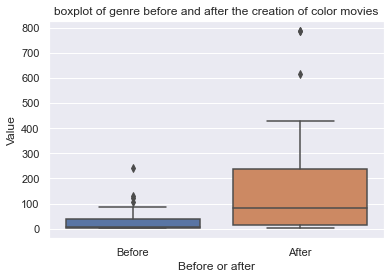

In [73]:
sns.boxplot(data = df, x = 'Before or after', y = 'Value')
plt.title('boxplot of genre before and after the creation of color movies')

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Text(0.5, 1.0, 'black and white cinema during the last century\n before and after the first film in color')

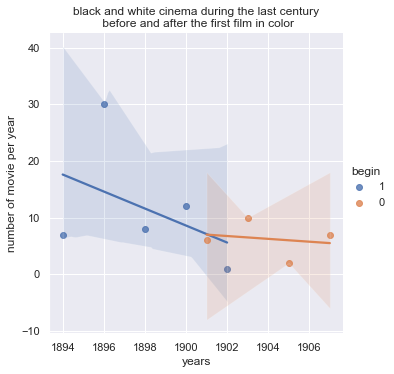

In [74]:
two_trends(event, 12, "black and white", 6, 1)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('black and white cinema during the last century\n before and after the first film in color')

Text(0.5, 1.0, 'black and white cinema during the last century')

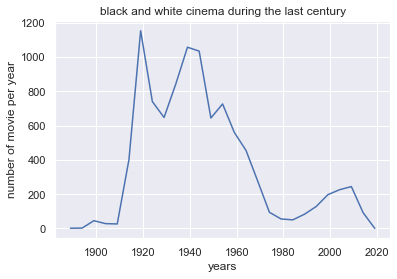

In [75]:
plt.plot(genre_per_date.resample("5Y").sum()['black and white'])
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('black and white cinema during the last century')

We can observe through the graphs and t test analysis that there is a modification of black and white movie production after the release of the first color film. However we can see that the expected drop does not occur immediatly after the apparition of the this technology and there is a delay until it's popularisation. This might be interesting to investigate on why such a delay occured.

In [76]:
fig = px.line(genre_per_date.resample("2Y").sum()['silent'], labels = {'value': 'number of movie per year'}, title = 'Silent cinema during the last century')
fig.add_vline(x = pd.to_datetime(1927, format ="%Y"))
fig.show()

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [77]:
y_event = 1927

In [78]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
pingouin.ttest(x = df.iloc[:, 0], y = df.iloc[:, 1], paired =True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.785337,23,two-sided,0.010518,"[-240.13, -35.45]",0.655804,4.641,0.867811


we observe a low p value, and we can therefore say that the distributions are not generated from the same process

In [79]:
df.columns = ["Before", "After", "Drop"]
df.fillna(0, inplace =True)
df.drop(columns ="Drop", inplace =True)
df = df.stack().reset_index().rename(columns ={"level_0": "genre", "level_1": "Before or after", 0: "Value"})


Text(0.5, 1.0, 'boxplot of silent cinema during the last century\n before and after the first film with sound')

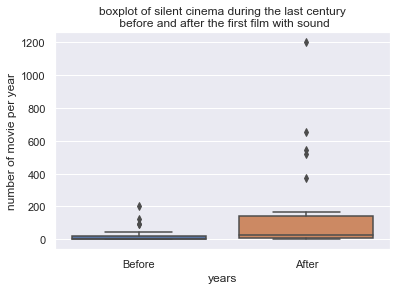

In [80]:
sns.boxplot(data = df, x = 'Before or after', y = 'Value')
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('boxplot of silent cinema during the last century\n before and after the first film with sound')

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Text(0.5, 1.0, 'silent cinema during the last century\n before and after the first film with sound')

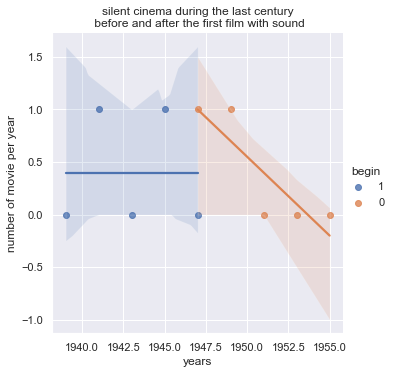

In [81]:
two_trends(event, 10, "silent", 7, 1)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('silent cinema during the last century\n before and after the first film with sound')

Text(0.5, 1.0, 'silent cinema during the last century')

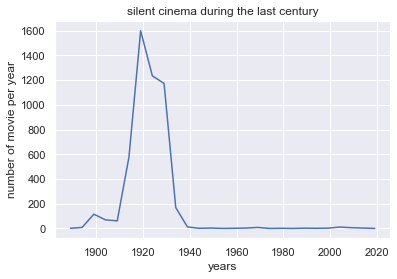

In [82]:
plt.plot(genre_per_date.resample("5Y").sum()['silent'])
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('silent cinema during the last century')

Here again we observe that technological advances have an impact on movie production. However we observe that the apparition of a new technology is not necessarily impacting directly the industry but might have a delay.

Other research event on technology/cinema for next milestone can be television, internet or netflix. Here again having shown the difference before/after the event we want to observe the impact on other metadata.

##### Other research directions:
Now that we have a pipeline to obtain our data and observe the movies relations with historical events we want to see if other types of event can also be observed in movies or not. The other major event types that we want to observe are political, economical and civil rights.

### Use of KATS library to detect outliers

The kats library is developped by facebook to treat timeseries data. It creates an object that has either one or multiple datatype all linked to a date.

In [83]:
# transform the war column to fit the kats format
war = rating_per_genre.copy()
war = war.groupby([war.index]).mean().reset_index()
war.rename(columns = {'release_date': 'time'}, inplace = True)

<class 'pandas.core.series.Series'>


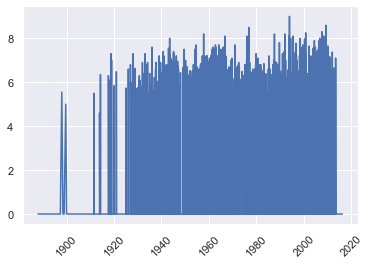

In [84]:
# trying the TimeSeriesData class from kats and the CUSUM detector that is part of the kats library and detect the change point automatically
war_time = TimeSeriesData(war.loc[:, ['time', 'war']])
print(type(war_time.value))
# detect decrease
detector = CUSUMDetector(war_time)
# run detector
change_points = detector.detector()

# plot the results
detector.plot(change_points)
plt.xticks(rotation =45)
plt.show()


we can see that the data day to day is too unstable and it has to be resampled to be used

In [85]:
def get_interval(data, window, time):
    """return the interval of time around the event

    Args:
        data (dataframe): the time series data with the date as index
        window (int ): the number of years before and after the event
        time (int): the date of the event format YYYY

    Returns:
        dataFrame: the interval of time around the event
    """
    time = pd.to_datetime(time, format ="%Y")
    interval = data[time - relativedelta(years =window): time + relativedelta(years =window)] 
    return interval


There are different types of detectors coded in the kats library including the CUSUM detector that allows one to choose a windows of interest and the Robust stats detector that allows to find multiple change points

In [86]:
def find_trend_change(data, resampling_rate, algo, col_of_interest, mean = False):
    """find a trend change around the event

    Args:
        data (dataframe): the time series data
        resampling_rate (_type_): the rate of resampling
        algo_resample (function): what do we want to do with the resamped data
        algo (kats.detectors): the trend change detection algorithm

    Returns:
        _type_: the change points outputed by the algorithm
    """
    interval = data
    #interval = get_interval(data, window, event)
    #time = pd.to_datetime(event, format ="%Y")
    if mean:
        interval = interval.replace(0,np.nan).resample(resampling_rate).mean().reset_index().rename(columns = {'release_date': 'time'}).iloc[:-1, :]
    else:
        interval = interval.resample(resampling_rate).sum().reset_index().rename(columns = {'release_date': 'time'})
    interval = TimeSeriesData(interval.loc[:, ['time', col_of_interest]])
    detector = algo(interval)
    change_points = detector.detector()
    #change_points = detector.detector(interest_window = [110, 120])
    plt.rcParams['figure.figsize'] = [20, 5]
    detector.plot(change_points)
    plt.savefig('totcountwar10.png')
    return change_points

[TimeSeriesChangePoint(start_time: 1968-12-31T00:00:00.000000000, end_time: 1968-12-31T00:00:00.000000000, confidence: 0.9990933321755493),
 TimeSeriesChangePoint(start_time: 1973-12-31T00:00:00.000000000, end_time: 1973-12-31T00:00:00.000000000, confidence: 0.9978928896076358),
 TimeSeriesChangePoint(start_time: 1992-12-31T00:00:00.000000000, end_time: 1992-12-31T00:00:00.000000000, confidence: 0.9955322492219442)]

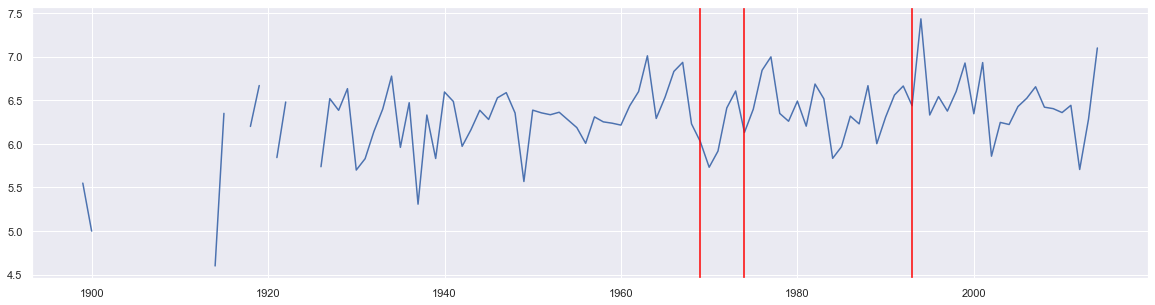

In [87]:
find_trend_change(rating_per_genre, "Y", RobustStatDetector, 'war', True)

[TimeSeriesChangePoint(start_time: 1941-12-31T00:00:00.000000000, end_time: 1941-12-31T00:00:00.000000000, confidence: 0.9995910197594144),
 TimeSeriesChangePoint(start_time: 1946-12-31T00:00:00.000000000, end_time: 1946-12-31T00:00:00.000000000, confidence: 0.9998423603461415),
 TimeSeriesChangePoint(start_time: 2010-12-31T00:00:00.000000000, end_time: 2010-12-31T00:00:00.000000000, confidence: 0.9947244966277557)]

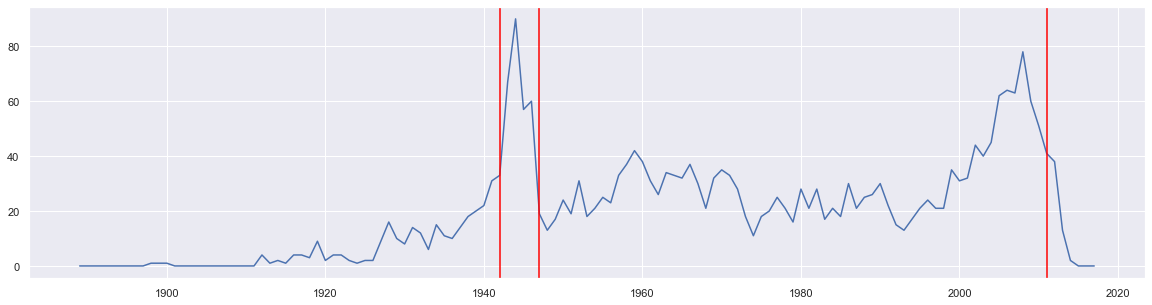

In [88]:
find_trend_change(genre_per_date, "Y", RobustStatDetector, 'war', False)

In [89]:
def find_local_trend_change(data, event, window, resampling_rate, algo, col_of_interest, mean = False):
    """find a trend change around the event

    Args:
        data (dataframe): the time series data
        event (datetime ): the date of the event format YYYY
        window (int): the number of years before and after the event that we want to consider
        resampling_rate (_type_): the rate of resampling
        algo_resample (function): what do we want to do with the resamped data
        algo (kats.detectors): the trend change detection algorithm
        col_of_interest (str): the column of interest
        mean (bool, optional): if we want to resample the data by the mean or the sum. Defaults to False(sum).


    Returns:
        _type_: the change points outputed by the algorithm
    """
    interval = get_interval(data, window, event)
    if mean:
        interval = interval.replace(0, np.nan).resample(resampling_rate).mean().reset_index().rename(columns = {'release_date': 'time'}).iloc[:-1, :]
    else:
        interval = interval.resample(resampling_rate).sum().reset_index().rename(columns = {'release_date': 'time'})
    interval = TimeSeriesData(interval.loc[:, ['time', col_of_interest]])
    detector = algo(interval)
    start = int(event-window+11)
    end = int(event+window+11)
    change_points = detector.detector()
    plt.rcParams['figure.figsize'] = [20, 5]
    detector.plot(change_points)
    plt.savefig('image/bast_img/' + "Vietnamcount" + col_of_interest + str(2*(window-10))+'.png')
    return change_points

[]

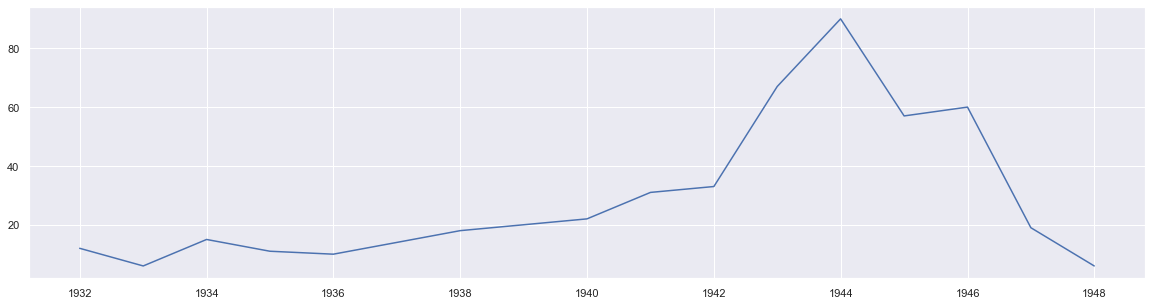

In [90]:
find_local_trend_change(genre_per_date, 1939, 8, "Y", CUSUMDetector, 'war', False)

[]

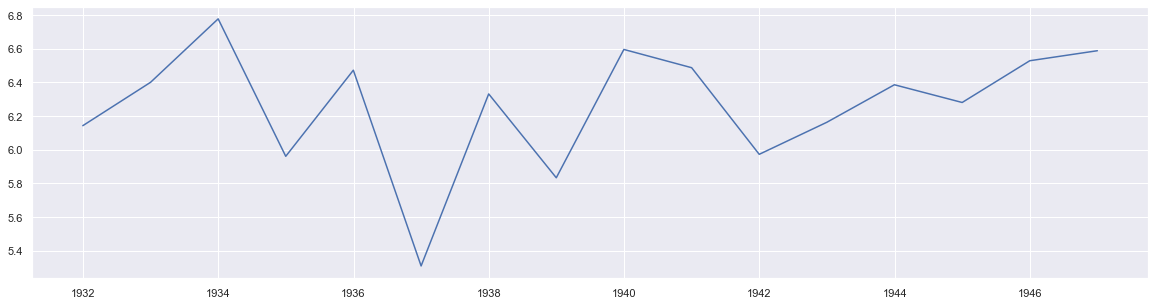

In [91]:
find_local_trend_change(rating_per_genre, 1939, 8, "Y", CUSUMDetector, 'war', True)

## Sentiment analysis and genres


### sentiment valence per genre

In [92]:
sentiment_dummies.head(5)

,wiki_id,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,...,thriller,war,western,action_type,romance_type,comedy_type,horror_type,experimental_type,fantasy_type,other_type
release_date,,,,,,,,,,,,,,,,,,,,,
1893-01-01,-0.585900,0.0,0.0,0.000000,-0.585900,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.585900,0.0,0.0
1894-10-09,0.476700,0.0,0.0,0.000000,0.476700,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.476700,0.0,0.0
1894-11-17,0.802000,0.0,0.0,0.000000,0.802000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.802000,0.0,0.0
1895-01-01,0.241687,0.0,0.0,0.241687,0.241687,0.241687,0.0,0.0,0.241687,0.0,...,0.0,0.0,0.0,0.0,0.0,0.241687,0.0,0.241687,0.0,0.0
1895-06-12,-0.051600,0.0,0.0,0.000000,-0.051600,0.000000,0.0,0.0,-0.051600,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.051600,0.0,0.0


<AxesSubplot:xlabel='release_date'>

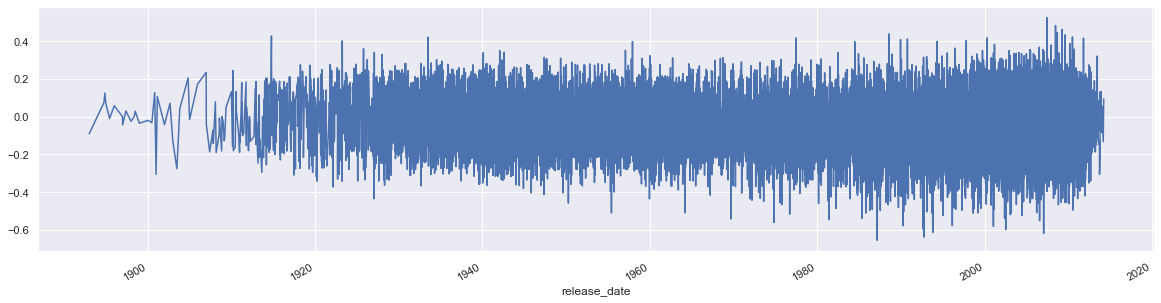

In [93]:
sentiment_dummies.mean(axis = 1).plot()

we see again that without resampling the data is way too noisy

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



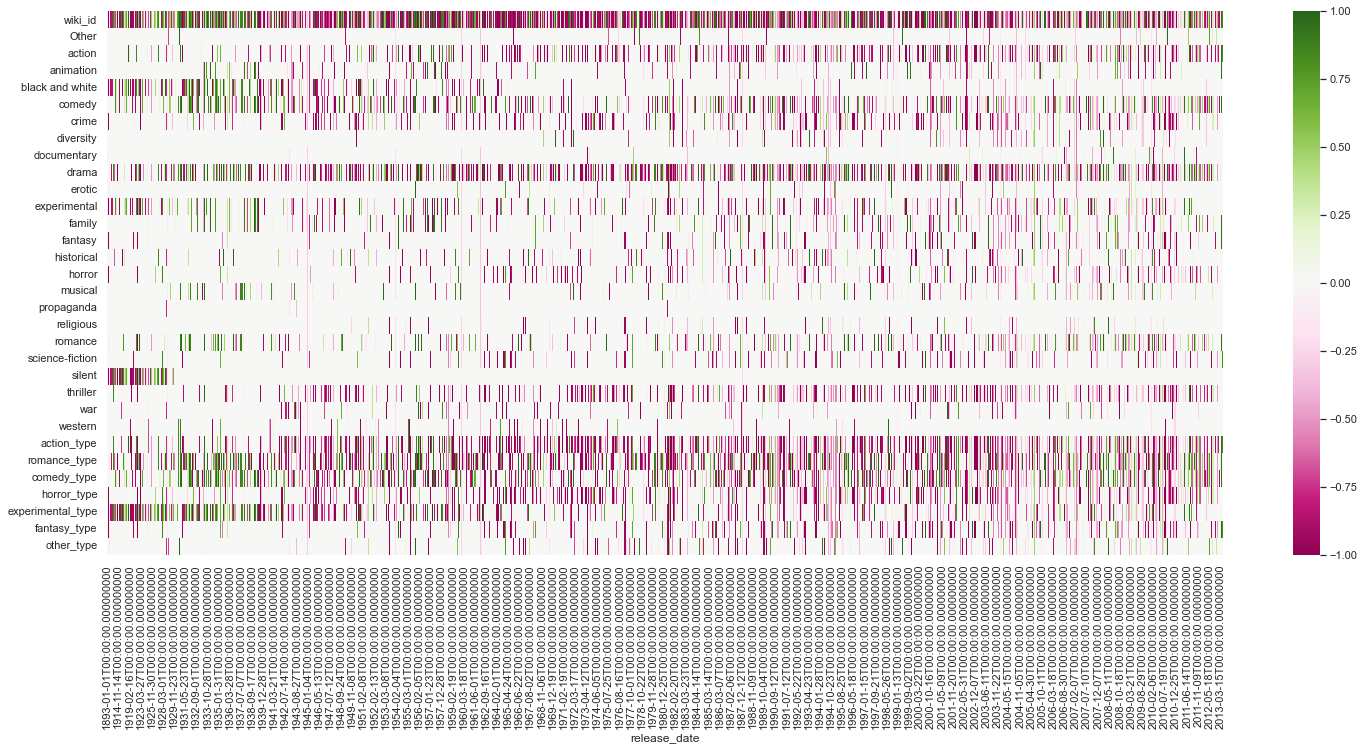

In [94]:
plt.figure(figsize = (25, 10))
ax = sns.heatmap(data = sentiment_dummies.transpose(), vmax =1, vmin =-1, center =0, cmap ="PiYG")

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



Text(0.5, 21.5, 'years')

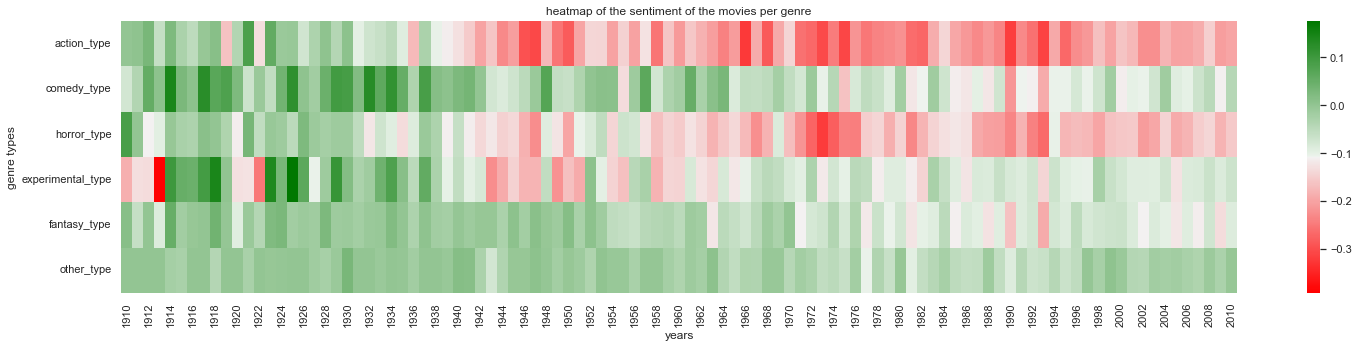

In [95]:
#px.line(get_interval(sentiment_dummies, 8, pd.to_datetime(1967, format ="%Y")).drop(['Unnamed: 0', 'averageRating'], axis =1).resample("3M").mean())
test = sentiment_dummies.groupby(sentiment_dummies.index).mean()
test = test[['action_type', 'comedy_type', 'horror_type', 'experimental_type', 'fantasy_type', 'other_type']]
test = test.fillna(0)
test = test.resample("Y").mean()
test = test.groupby(test.index.year).mean()
test = test.loc[1910:2010, :]
#test = test.pct_change()
test = test.transpose()
plt.figure(figsize = (25, 5))

palette = sns.diverging_palette(10, 120, s=270, l =40, center ="light", as_cmap =True)
ax = sns.heatmap(data = test, cmap =palette)
plt.title('heatmap of the sentiment of the movies per genre')
plt.ylabel('genre types')
plt.xlabel('years')


In [96]:
def heat_sentiment(data, event, window, resampling_rate, cols_to_drop = []):
    """plot a heatmap of the sentiment around the event

    Args:
        data (dataframe): the time series data
        event (datetime ): the date of the event
        window (int): the number of years before and after the event that we want to consider
        resampling_rate (_type_): the rate of resampling
        cols_to_drop (list): the columns we want to drop

    Returns:
        _type_: the change points outputed by the algorithm
    """
    interval = get_interval(data, window+1, event)
    interval = interval[['action_type', 'comedy_type', 'horror_type', 'experimental_type', 'fantasy_type', 'other_type']]

    interval = interval.resample(resampling_rate).mean().reset_index()
    interval.set_index(interval.release_date.dt.year, inplace =True)
    interval.drop(['release_date'], axis =1, inplace =True)
    interval.drop(cols_to_drop, axis =1, inplace =True)
    #print(interval)
    plt.figure(figsize = (25, 5))
    palette = sns.diverging_palette(10, 120, s=270, l =40, center ="light", as_cmap =True)
    ax =sns.heatmap(interval.transpose().iloc[:, 1:-1], xticklabels =2, cmap = palette)
    ax.axvline(window, c = 'b', lw =5)
    plt.title('heatmap of the sentiment of the movies per genre')
    plt.ylabel('genre types')
    plt.xlabel('years')
    plt.show()
    return ax

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



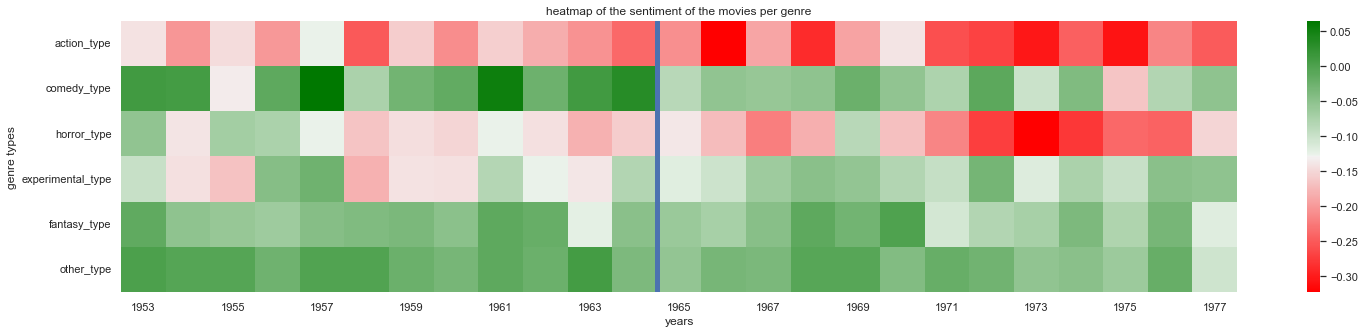

<AxesSubplot:title={'center':'heatmap of the sentiment of the movies per genre'}, xlabel='years', ylabel='genre types'>

In [97]:
heat_sentiment(sentiment_dummies, 1965, 12, "Y")

The heatmaps per bag of genre are easyer to understand and it is nice to be able to 'zoom' into certain period that give a nice output.

In [98]:
def plot_sentiment(data, event, window):
    """plot the value of use of positive, neutral and negative words around the event

    Args:
        data (DataFrame): the sentiment data
        event (int): the date of the event
        window (int): the number of years before and after the event that we want to consider
    """

    data = data.groupby(data.index).mean()
    data = get_interval(data, window, event)
    data = data.groupby(data.index.year).mean().reset_index()
    data = pd.concat([data[['release_date', 'pos']].rename(columns ={'pos': 'val'}) ,data[['release_date', 'neu']].rename(columns ={'neu': 'val'}),
                            data[['release_date', 'neg']].rename(columns ={'neg': 'val'})], keys = ["neu", "pos", "neg"])
    data.reset_index(inplace =True)

    f, ax = plt.subplots(figsize =(20, 6))
    ax = sns.lineplot(data = data, x ="release_date", y = 'val', hue ="level_0")
    ax.grid(True)
    
    #ax.set_yscale('log')
    plt.show()


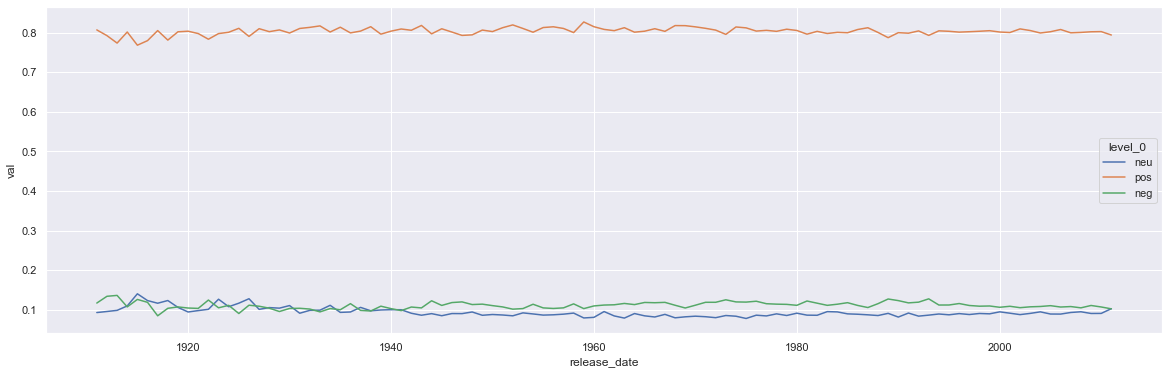

In [99]:
plot_sentiment(sent, 1961, 50)

### Wordclouds to get topics importance per genre

In [100]:
#process the text to feed into the wordcloud functions
def clean_text(text: str):
    text_lower = text.lower()
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops = [token for token in tokens if token not in stopwords.words("english")]
    return " ".join(no_stops)

In [101]:
#performs a split between positive, negative and neutral words
def pos_neut_neg_split(x: str):
    pos_word_list = []
    neg_word_list = []
    neu_word_list = []

    for word in x.split():
        testimonial = TextBlob(word)
        if testimonial.sentiment.polarity >= 0.3:
            pos_word_list.append(word)
        elif testimonial.sentiment.polarity <= -0.3:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)

    return pos_word_list, neu_word_list, neg_word_list

In [102]:
if path.exists('data/word_cloud.csv'):
    word_cloud = pd.read_csv('data/word_cloud.csv')
    word_cloud.release_date = pd.to_datetime(word_cloud.release_date)
    word_cloud["pos_words"] = word_cloud["pos_words"].astype(str)
    word_cloud["neg_words"] = word_cloud["neg_words"].astype(str)
else:
    plots.rename(columns ={'movie_id': 'wiki_id'}, inplace =True)
    plots["wiki_id"] = plots["wiki_id"].astype(int)
    word_cloud = pd.merge(plots, metadata, on = 'wiki_id')
    word_cloud["plot"] = word_cloud["plot"].astype(str)
    word_cloud["clean_plot"] = word_cloud["plot"].apply(clean_text)
    word_cloud["clean_plot_div"] = word_cloud.clean_plot.apply(pos_neut_neg_split)
    cols = ["pos", "neut", "neg"]
    for i,col in enumerate(cols):
        word_cloud[col+"_words"] = word_cloud["clean_plot_div"].apply(lambda x:x[i])
        word_cloud["n_"+col+"_words"] = word_cloud[col+"_words"].apply(len)
        word_cloud[col+"_words"] = word_cloud[col+"_words"].apply(lambda x: " ".join(x))
    word_cloud.to_csv('data/word_cloud.csv', index =True)

In [103]:
def get_time_wordcloud(data, window, event, genre, type_words = None):
    """plot a wordcloud of the most important words per genre around the event

    Args:
        data (dataframe): the time series data
        event (datetime ): the date of the event
        window (int): the number of years before and after the event that we want to consider
        genre (str): the genre we want to plot
        type_words (str, optional): the type of words we want to plot. Defaults to None (all words are used).
        
    Returns:
        nothing
    """

    data = pd.merge(data.replace(['nan', 'phillip', 'jack', 'charlene', 'emily'], '').groupby('release_date').agg((" ".join)), data.replace('nan', '').groupby('release_date').mean(), on = 'release_date')
    interval = get_interval(data, window, event)
    my_stopwords = []
    stopwords = set(wordcloud.STOPWORDS).update(my_stopwords)
    if type_words == None:
        interval = interval.groupby(genre)["clean_plot"].agg((" ".join)).reset_index()
        cloud = WordCloud(stopwords =stopwords).generate(interval["clean_plot"][1])
        type_words ="all"
    else:
        interval = interval.groupby(genre)[type_words].agg((" ".join)).reset_index()
        cloud = WordCloud(stopwords =stopwords).generate(interval[type_words][1])
    plt.imshow(cloud, interpolation = "bilinear")
    plt.show()
    plt.savefig('image/Vietnam'+genre+ str(window*2)+ str(event)+type_words+'.png')


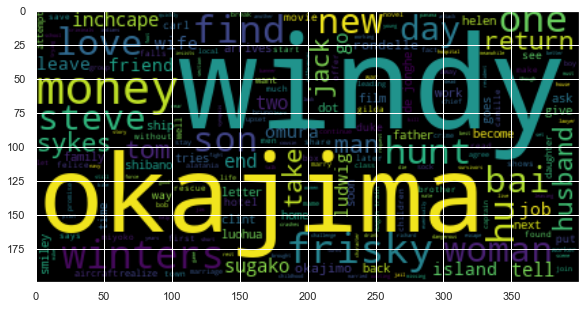

<Figure size 1440x360 with 0 Axes>

In [104]:
get_time_wordcloud(word_cloud, 5, 1934, "comedy", None)

In [105]:
def get_time_wordcloud_before(data, window, events, genre, type_words = None):
    """plot a wordcloud of the most important words per genre around the event

    Args:
        data (dataframe): the time series data
        events (array of datetimes): the date of the events
        window (int): the number of years before and after the event that we want to consider
        genre (str): the genre we want to plot
        
    Returns:
        nothing
    """
    ls = []
    data = data.replace('nan', '')
    data.clean_plot = data.clean_plot.str.replace('phillip', '').str.replace('jack', '').str.replace('charlene', '').str.replace('emily', '').str.replace('chuck', '')
    data.pos_words = data.pos_words.str.replace('phillip', '').str.replace('jack', '').str.replace('charlene', '').str.replace('emily', '')
    data.neut_words = data.neut_words.str.replace('phillip', '').str.replace('jack', '').str.replace('charlene', '').str.replace('emily', '')
    data.neg_words = data.neg_words.str.replace('phillip', '').str.replace('jack', '').str.replace('charlene', '').str.replace('emily', '')
    data = pd.merge(data.groupby('release_date').agg((" ".join)), data.groupby('release_date').mean(), on = 'release_date')   
    for event in events:
        ls.append(get_interval(data, window, event))
    interval = pd.concat(ls)
    my_stopwords = []
    stopwords = set(wordcloud.STOPWORDS).update(my_stopwords)
    if type_words == None:
        interval = interval.groupby(genre)["clean_plot"].agg((" ".join)).reset_index()
        cloud = WordCloud(stopwords =stopwords).generate(interval["clean_plot"][1])
        type_words ="all"
    else:
        interval = interval.groupby(genre)[type_words].agg((" ".join)).reset_index()
        cloud = WordCloud(stopwords =stopwords).generate(interval[type_words][1])
    plt.imshow(cloud, interpolation = "bilinear")
    #plt.show()
    plt.savefig('image/afteraction.png')


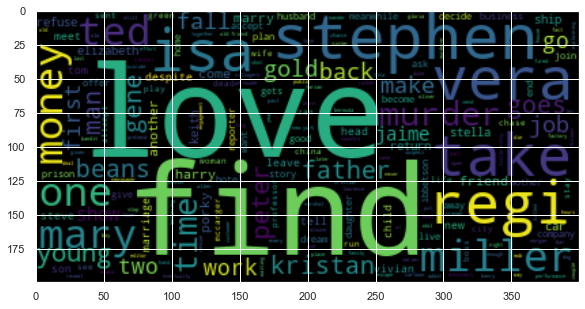

In [106]:
get_time_wordcloud_before(word_cloud, 5, [1939, 1955, 2001], "action", None)

The wordclouds are quite nice to observe the difference between two periods and by grouping the pre and post war periods respectively together we can observe a change in tone especially in comedies

## Sentiment analysis movie and countries

#### NLP for summary comprehension

The first step is to find a way to extract the countries and nationalities from the synopsys of every movie, as well as the sentiment for these countries. We decided to use Named Entity Recognition (NER) for this task. More specifically the transformer based pipeline provided by SpaCy.

In [107]:
#Initialise Vader sentiment analyzer and SpaCy NPC models

sentiment_analyzer = SentimentIntensityAnalyzer()
nlp_fast =spacy.load('en_core_web_sm')

# The trained transformer-based pipelines provided by spaCy are:en_core_web_trf
nlp = spacy.load('en_core_web_trf')

#Generate a small visualization of the plot summaries of the movie "Rambo"
doc = nlp(df_summaries.loc[13240]['plot'])
displacy.render(doc, style ="ent")

/home/bastienll/Anaconda3/lib/python3.9/site-packages/spacy/displacy/__init__.py:70: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [108]:
def clean_string(x:str) -> list:
    """Returns the lemmatized of every word in the input

    Args:
        x (str): Contains the input to be lemmatized

    Returns:
        list: a list of the words lemmatized
    """
    
    # Create a stemmer, the Lancaster Stemmer is used here
    doc = nlp_fast(x)
    # Return a list of Stemmed words
    return " ".join([token.lemma_.capitalize() for token in doc if not token.is_stop])

#### Location Analysis

Once we have extracted the name of all the locations present in the synopsys we need to find it's country and location on a map. Therefore we use a geocode locator to extract the latitude and longitude, with a url request from the openstreetmap to get the country. This combinations allows us to not overcharge the geocode requests.

In [109]:
# Setup geocode and locator
user_agent = 'user_me_{}'.format(randint(10000, 99999))
locator = Nominatim(user_agent =user_agent)
geocode = RateLimiter(locator.geocode, min_delay_seconds =1.2)

In [110]:
def find_country(country: str) -> str:
    """Returns the country of the location in the input

    Args:
        country (str): Name of the location (landmark, city, country...)

    Returns:
        str: the name of the country
    """
    address = geocode(country)
    if address is None:
        return "Other"
    lat = address.raw['lat']
    lon = address.raw['lon']
    url = f'https://nominatim.openstreetmap.org/reverse?lat ={lat}&lon ={lon}&format =json&accept-language =en&zoom =3'
    
    try:
        result = requests.get(url =url)
        result_json = result.json()
        return result_json['display_name']
    except Exception as e:
        return "Other"


In [111]:
def dict_mean(dict_list: list) -> dict:
    """Returns the mean value of each key in the dictionary list
    Args:
        dict_list (list): list of dictionaries with the same keys

    Returns:
        dict: dictionary with the mean value for each key
    """
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

In [112]:
def find_movie_location_and_sentiment(summary: str) -> object:
    """ Returns a series with the location and sentiment information for the input summary
    Args:
        summary (str): summary of the movie

    Returns:
        pd.Series: A pandas series with the following information:
                    - who: a dictionary with the mean sentiment for each nationality in the summary
                    - where: a dictionary with the mean sentiment for each location in the summary
                    - countries: a dictionary with the mean sentiment for each country in the summary
                    - vs_all: a dictionary with the mean sentiment for the summary
    """
    where = {}
    who = {}
    countries = {}
    
    # Define the NER algorythm to be trasformer based
    doc = nlp(summary)

    # Analyse the summary with Vader to get a general sentiment
    vs_all = sentiment_analyzer.polarity_scores(summary)

    # Loop through the sentences in the summary
    for sent in doc.sents :

        # Analyse the sentiment of each sentence
        phrase_sentiment = sentiment_analyzer.polarity_scores(str(sent))

        # Loop through the entities in the sentence
        for ent in sent.ents :

            # If the entity is a location, add it to the where dictionary, and it's country to the countries dictionary
            if ent.label_ in ['GPE']:

                country = find_country(clean_string(ent.text))

                # If the location is already in the dictionary, add the sentiment to the list
                if clean_string(ent.text) in where:
                    where[clean_string(ent.text)].append(phrase_sentiment)
                else:
                    where[clean_string(ent.text)] = list([phrase_sentiment])

                # If the country is already in the dictionary, add the sentiment to the list
                if country in countries:
                    countries[country].append(phrase_sentiment)
                else:
                    countries[country] = list([phrase_sentiment])

            # If the entity is a Nationality, add it to the who dictionary
            if ent.label_ in ['NORP']:

                # If the nationality is already in the dictionary, add the sentiment to the list
                if clean_string(ent.text) in who:
                    who[clean_string(ent.text)].append(phrase_sentiment)
                else:
                    who[clean_string(ent.text)] = list([phrase_sentiment])

    # Calculate the mean sentiment for each repeated location
    for key,value in where.items():
        dict_mean(value)
        where[key] = dict_mean(value)
    
    # Calculate the mean sentiment for each repeated nationality
    for key,value in who.items():
        who[key] = dict_mean(value)

    # Calculate the mean sentiment for each repeated country
    for key,value in countries.items():
        countries[key] = dict_mean(value)

    return pd.Series([who, where, countries, vs_all])
 


Since the geolocation takes a while due to the 1 sec wait, we created subsets of the dataframe that we later stitched together in order to better handle errors

In [113]:
#careful if the file is not already created, it will take a very long time to run
if path.exists('data/country_sentiment_stitch.csv'):
    final_df = pd.read_csv('data/country_sentiment_stitch.csv')
else:
    # Apply the function to the dataframe 
    df_summaries[['who', 'where', 'country', 'sentiment']] = df_summaries['plot'].apply(lambda x: find_movie_location_and_sentiment(x))
    #this is very long, be careful if you launch it
    # Setup subset sizes 
    maxval = len(df_summaries)
    step = 1000
    i = 0

    # Loop through the dataframe in subsets of 1000 rows
    while i*step + step < maxval:
        print("Step ", i)
        # Change the user agent to avoid being blocked by the API
        user_agent = 'user_me_{}'.format(randint(10000,99999))
        locator = Nominatim(user_agent =user_agent)
        geocode = RateLimiter(locator.geocode, min_delay_seconds =1)

        # Process the subset and save it to a csv
        df_summaries_trunc = df_summaries[i*step:i*step + step]
        df_summaries_trunc[['who', 'where', 'country', 'sentiment']] = df_summaries_trunc['plot'].apply(lambda x: find_movie_location_and_sentiment(x))
        df_summaries_trunc.to_csv('tmp_stitches/country_sentiment_stitch_'+ str(i) + '.csv', index =True)
        i+=1

    # Process the last subset not in the step size
    df_summaries_trunc = df_summaries[i*step: maxval - i*step]
    df_summaries_trunc[['who', 'where', 'country', 'sentiment']] = df_summaries_trunc['plot'].apply(lambda x: find_movie_location_and_sentiment(x))
    df_summaries_trunc.to_csv('tmp_stitches/country_sentiment_stitch_' + str(i) + '.csv', index =True)
    # Stitch the subsets together

    final_df = pd.read_csv('tmp_stitches/country_sentiment_stitch_'+ str(0) + '.csv', header =0, index_col =0)

    for i in range(1, 43):
        tmp_df = pd.read_csv('tmp_stitches/country_sentiment_stitch_'+ str(i) + '.csv', header =0, index_col =0)
        final_df = pd.concat([final_df, tmp_df], ignore_index =True)

    # Check the final dataframe size for errors
    print(len(final_df))

    # Convert the read files to the correct format, mainly dictionaries
    final_df[['who', 'where', 'country', 'sentiment']] = final_df[['who', 'where', 'country', 'sentiment']].applymap(literal_eval)
    # Save the final dataframe with the stitched subsets
    final_df.to_csv('data/country_sentiment_stitch.csv', index =True)

## Sentiment analysis and movie topics

# Visualisations

## World at war

## Talking about this country

In [114]:
df_summaries = final_df.copy()
movies =pd.read_table('./data/movie.metadata.tsv', header =None)
movies.rename(columns ={0: 'wikipedia_movie_id', 1: 'rebase_movie_ID', 2: 'Movie_name', 3: 'Movie_release', 4: 'Box_office_revenue', 5: 'Movie_runtime', 6: 'Movie_language', 7: 'Movie_country', 8: 'Movie_genre'}, inplace =True)


### Data formatting for plots

We first need to join information together in order to plot the desired information. We decided to do an analysis by country and not by location since we have more data by country and the results are better for our data story.

In [115]:
# Read the country and sentiment information dataframe
df_summaries[['who', 'where', 'country', 'sentiment']] = df_summaries[['who', 'where', 'country', 'sentiment']].applymap(literal_eval)

# Check if there are no errors
print(len(df_summaries))

42204


In [116]:
# Setup geocode and locator
user_agent = 'user_me_{}'.format(randint(10000, 99999))
locator = Nominatim(user_agent =user_agent)
geocode = RateLimiter(locator.geocode, min_delay_seconds =1.2)

In [117]:
# Generate a copy for safety
movies_copy = movies.copy()

# Convert the release date to a year and merge with the summaries
movies_copy['Movie_release'] = pd.to_datetime(movies_copy['Movie_release'], errors = 'coerce').dt.year
df_summaries_dated = pd.merge(df_summaries, movies_copy[['wikipedia_movie_id', 'Movie_release', 'Movie_country', 'Movie_name']], on = 'wikipedia_movie_id')

# Extract the desired information from the dictionaries format of where, who, country and sentiment
df_summaries_dated['countries'] = df_summaries_dated['country'].apply(lambda x: list(x.keys()))
df_summaries_dated['where_key'] = df_summaries_dated['where'].apply(lambda x: str(list(x.keys())))
df_summaries_dated['country_sentiment'] = df_summaries_dated['country'].apply(lambda x: [list(dict(k).values())[3] for k in list(x.values())] if len(x.values()) else [])
df_summaries_dated['general_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x: list(dict(x).values())[3])
df_summaries_dated['positive_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x: list(dict(x).values())[2])
df_summaries_dated['negative_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x: list(dict(x).values())[0])
df_summaries_dated['Movie_country'] = df_summaries_dated['Movie_country'].apply(lambda x: literal_eval(x).values())

# Sort values by Movie release and wikipedia movie id to check if there are no errors
df_summaries_dated = df_summaries_dated[['wikipedia_movie_id', 'Movie_name_y', 'Movie_country', 'Movie_release', 'countries', 'country_sentiment', 'where_key', 'general_sentiment',
                                 'positive_sentiment', 'negative_sentiment']].sort_values(by = ['Movie_release', 'wikipedia_movie_id'], ascending = False)

# Generate one line per country
df_summaries_dated = df_summaries_dated.set_index(['wikipedia_movie_id', 'Movie_release', 'where_key', 'general_sentiment', 'Movie_country', 'Movie_name_y', 'positive_sentiment',
 'negative_sentiment']).apply(pd.Series.explode).reset_index()

# Create a new line that we will later use to count the number of movies per country
df_summaries_dated['production'] = 1

### Preliminary plots

We first started by doing some basic plots in order to see is the results we were getting from the data formatting were correct and if our data story had a strong basis

<AxesSubplot:title={'center':'Ratio of movies per year per country'}, xlabel='Year', ylabel='Percentage of country movies per total movie production'>

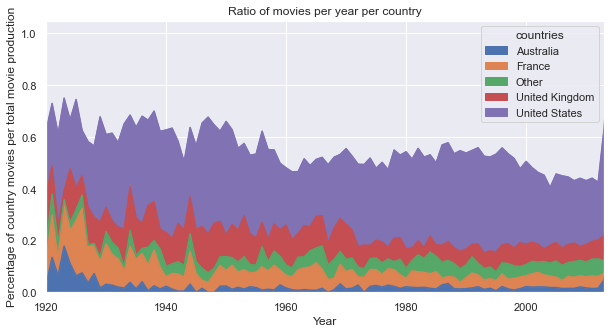

In [118]:
# select number of most popular countries to display
nbr_countries = 5

# Create a pivot table with the number of movies per country per year
pt_prod = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['production'], aggfunc =np.sum)

# Scale the data by the total number of movies per year
pt_prod = pt_prod.divide(pt_prod.sum(axis = 'columns'), axis = 'index')

# Select the top nbr_countries countries and plot the data
s = pt_prod.sum(axis = 'index')
indx = list(s.sort_values(ascending =False).index[:nbr_countries].get_level_values('countries'))
pt_prod.columns = pt_prod.columns.get_level_values('countries')
pt_prod = pt_prod[np.intersect1d(pt_prod.columns, indx)]

pt_prod.fillna(0).plot.area(stacked =True, figsize =(10, 5), xlim =(1920, 2013), xlabel = 'Year', ylabel = 'Percentage of country movies per total movie production', title = 'Ratio of movies per year per country')

<AxesSubplot:title={'center':'Average sentiment per year per country'}, xlabel='Year', ylabel='Average sentiment'>

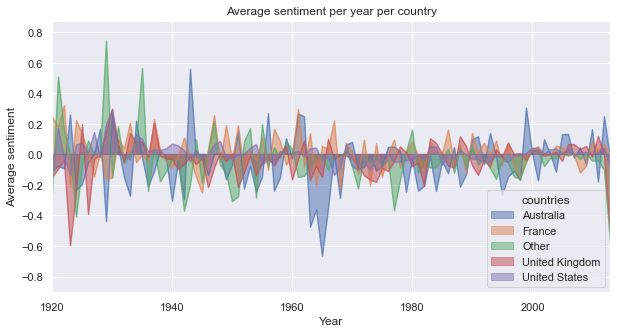

In [119]:
# Plot the average sentiment per country per year, using the phrase sentiment as a proxy for the country sentiment

pt_c_sent = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['country_sentiment'], aggfunc =np.mean)
pt_c_sent.columns = pt_c_sent.columns.get_level_values('countries')
pt_c_sent = pt_c_sent[np.intersect1d(pt_c_sent.columns, indx)]

pt_c_sent.fillna(0).plot.area(stacked =False, figsize =(10, 5), xlim =(1920, 2013), xlabel = 'Year', ylabel = 'Average sentiment', title = 'Average sentiment per year per country')

<AxesSubplot:title={'center':'Average sentiment per year per country'}, xlabel='Year', ylabel='Average sentiment'>

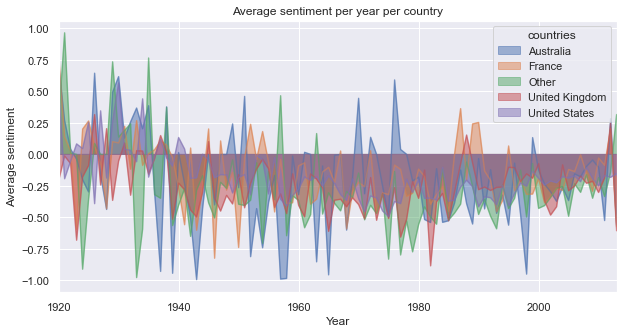

In [120]:
# Plot the average sentiment per country per year, using the summary sentiment as a proxy for the country sentiment

pt_g_sent = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['general_sentiment'], aggfunc =np.mean)
pt_g_sent.columns = pt_g_sent.columns.get_level_values('countries')
pt_g_sent = pt_g_sent[np.intersect1d(pt_g_sent.columns, indx)]

pt_g_sent.fillna(0).plot.area(stacked =False, figsize =(10, 5), xlim =(1920, 2013), xlabel = 'Year', ylabel = 'Average sentiment', title = 'Average sentiment per year per country')

### Sentiment decision

From the two plots above, we can see that the general sentiment of the movies follow a stronger pattern. Common sense also made us lean towards general movie sentiment since The specific phrase where a country is mentioned may not always show the general sentiment given by the movie to that country.

The fact that the sentiment is less strong for these phrases is because Vader has more trouble finding the sentiment of small texts and the cumulative score given is often 0.

Since we are only interested in the difference in movie production per country and not the difference between countries, we did not set the same y axis for all the countries.

In [121]:
# Select countries to plot
country_list = ["Iraq", "Iran", "Afghanistan", "Vietnam", "Algeria", "Russia", "France", "Germany", "United States"]
# Define major wor periods for each country
war_dates = [
    [[1980, 1988], [1990, 1991], [2003, 2011]], # Iraq
    [[1980, 1988], [1963, 1978]], # Iran
    [[1979, 1989], [2001, 2021]], # Afghanistan
    [[1955, 1975], [1977, 1991], [1979, 1980]], # Vietnam
    [[1939, 1945], [1954, 1962]], # Algeria
    [[1939, 1945], [1947, 1991], [1979, 1989]], # Russia
    [[1939, 1945], [1954, 1962]], # France
    [[1939, 1945]], # Germany
    [[1939, 1945], [1947, 1991], [1955, 1975], [2003, 2011], [1979, 1989]], # United States
]

# Prepare data for plotting as done before
pt_prod = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['production'], aggfunc =np.sum)
pt_g_sent = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['general_sentiment'], aggfunc =np.mean)
pt_prod.columns = pt_prod.columns.get_level_values('countries')
pt_g_sent.columns = pt_g_sent.columns.get_level_values('countries')

pt_prod = pt_prod.divide(pt_prod.sum(axis = 'columns'), axis = 'index')


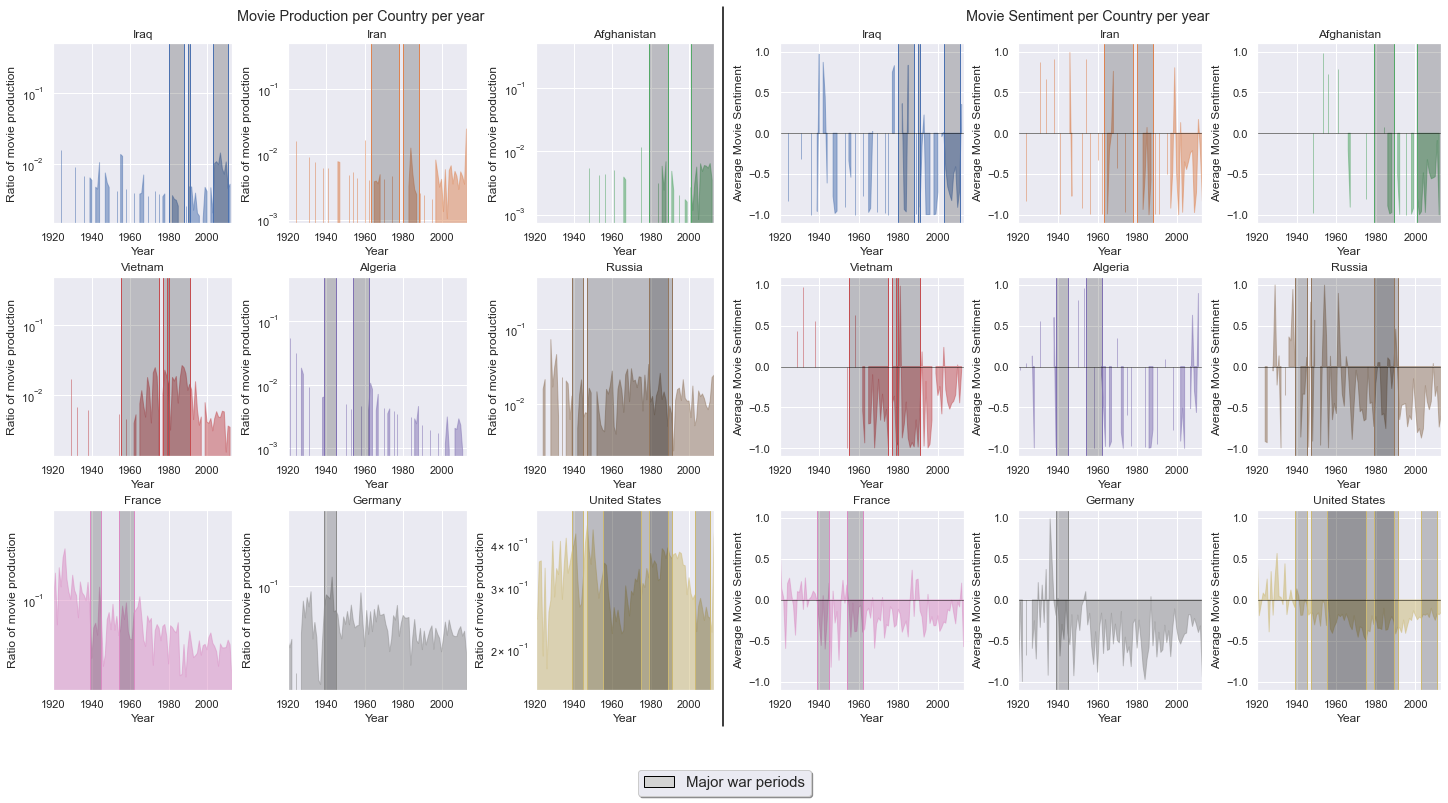

In [122]:
fig = plt.figure(constrained_layout =True, figsize =(20, 10)) 

# Create a grid of two subplots
subfigs = fig.subfigures(1, 2)
subfigs_flat = subfigs.flat
subfigs_flat[0].suptitle("Movie Production per Country per year", fontsize = 'large')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Divide the subplot into a 3x3 grid
axs = subfigs_flat[0].subplots(3, 3)

# Iterate over the grids and plot the production data for each country
for innerind, ax in enumerate(axs.flat):

    ax.set_title(country_list[innerind])
    ax.fill_between(pt_prod.index, pt_prod[country_list[innerind]], alpha =0.5, color = color_cycle[innerind])
    ax.set_yscale('log')
    ax.set_xlim(1920, 2013)
    ax.set_ylim(None, 0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel("Ratio of movie production")

    # Add the war rectangles
    for i, war in enumerate(war_dates[innerind]):
        rect_fill = patches.Rectangle((war[0], 0), war[1]-war[0], 0.5,
         linewidth =1, edgecolor = 'black', facecolor = 'black', alpha =0.2)
         
        rect_outline = patches.Rectangle((war[0], 0), war[1]-war[0], 0.5,
         linewidth =1, edgecolor =color_cycle[innerind], facecolor = 'none', alpha =1)

        ax.add_patch(rect_fill)
        ax.add_patch(rect_outline)

# Plot a black line separating the two subplots
axs.flat[5].plot([1.05, 1.05], [2.5, -1.5], transform =axs.flat[5].transAxes, clip_on =False, color = 'black')

# Divide the subplot into a 3x3 grid and name it
subfigs_flat[1].suptitle("Movie Sentiment per Country per year", fontsize = 'large')
axs = subfigs_flat[1].subplots(3, 3)

# Iterate over the grids and plot the sentiment data for each country
for innerind, ax in enumerate(axs.flat):

    ax.set_title(country_list[innerind])
    ax.fill_between(pt_g_sent.index, pt_g_sent[country_list[innerind]], alpha =0.5, color = color_cycle[innerind])
    ax.set_xlim(1920, 2013)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Movie Sentiment")
    ax.axhline(y =0, color = 'black', linestyle = '-', linewidth =0.5)

    # Add the war rectangles
    for i, war in enumerate(war_dates[innerind]):
        rect_fill = patches.Rectangle((war[0], -1.1), war[1]-war[0], 2.2,
         linewidth =1, edgecolor = 'black', facecolor = 'black', alpha =0.2)
         
        rect_outline = patches.Rectangle((war[0], -1.1), war[1]-war[0], 2.2,
         linewidth =1, edgecolor =color_cycle[innerind], facecolor = 'none', alpha =1)
        ax.add_patch(rect_fill)
        ax.add_patch(rect_outline)

# Add a legend to the bottom of the figure
gray_patch = patches.Patch(edgecolor = 'Black', facecolor = 'lightgray', label = 'Major war periods')
fig.legend(handles = [gray_patch], loc = 'upper center', bbox_to_anchor =(0.5, -0.05),
          fancybox =True, shadow =True, prop ={'size': 15})

plt.show()

### Advanced Interactive plots

Now that we have the data we want to present, we can start working on our interactive plots.

The first plot will be a stacked area plot showing the ratio of movies per year that have a positive or negative sentiment.

In [123]:
# Define sentiment threshold for positive and negative sentiment
sentiment_threshhold = 0.2

# Create a new column for positive and negative sentiment
df_summaries_dated['pos'] = df_summaries_dated['general_sentiment'] > sentiment_threshhold
df_summaries_dated['neg'] = (-1)*(df_summaries_dated['general_sentiment'] < -sentiment_threshhold)

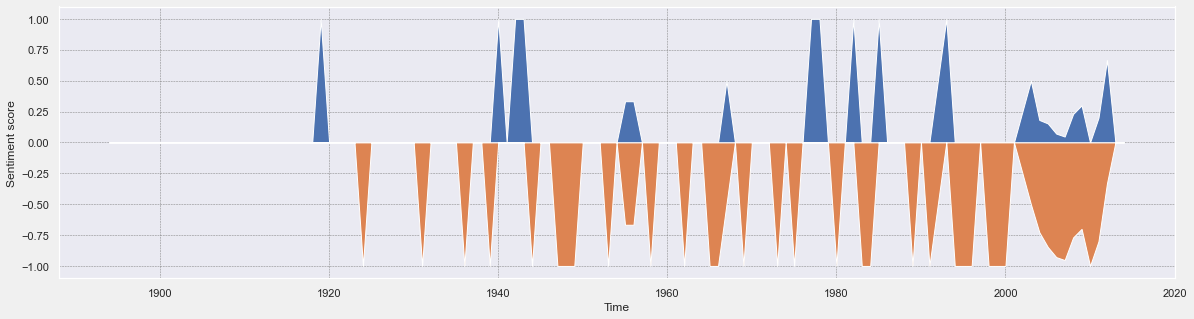

In [124]:
# Format data and generate a preliminary subplot so see if the output is correct

pt_prod_pos = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['pos'], aggfunc =np.sum)
pt_prod_neg = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['neg'], aggfunc =np.sum)
pt_prod = pd.pivot_table(df_summaries_dated, columns = ['countries'], index = ['Movie_release'], values = ['production'], aggfunc =np.sum)

pt_prod_pos.columns = pt_prod_pos.columns.get_level_values('countries')
pt_prod_neg.columns = pt_prod_neg.columns.get_level_values('countries')
pt_prod.columns = pt_prod.columns.get_level_values('countries')

pt_prod_pos = pt_prod_pos.divide(pt_prod, axis = 'index').fillna(0)
pt_prod_neg = pt_prod_neg.divide(pt_prod, axis = 'index').fillna(0)

fig, ax = plt.subplots(nrows =1, ncols =1, facecolor ="#F0F0F0")
ax.stackplot(pt_prod_pos.index, pt_prod_pos.Iraq)
ax.stackplot(pt_prod_pos.index, pt_prod_neg.Iraq)

ax.set_xlabel("Time")
ax.set_ylabel("Sentiment score")
ax.grid(which ="major", color ="grey", linestyle ="--", linewidth =0.5)

plt.show()

### Region Analysis

In order to get a better idea of movies, we will join countries by region, that way we can see how wart affects our vision of a whole region of the world.

In [125]:
if path.exists('data/df_summaries_region.csv') and path.exists('data/df_summaries_coordinates.csv'):
    # Load our table with all countries and their corresponding region
    df_summaries_region = pd.read_csv('./data/df_summaries_region.csv')
    df_summaries_coordinates = pd.read_csv('./data/df_summaries_coordinates.csv')
else:    
    # Load our table with all countries and their corresponding region
    region_map = pd.read_csv('./data/country_regions.csv',sep =", ", header =0)

    # Create a list with all the different regions and find their coordinates
    location_region_map = pd.DataFrame(region_map['region'].unique(), columns = ['region'])
    location_region_map['address'] = location_region_map['region'].apply(geocode)
    location_region_map['coordinates'] = location_region_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

    # Create a list with all the different countries and find their coordinates
    location_country_map = pd.DataFrame(df_summaries_dated['countries'].unique(), columns = ['countries'])
    location_country_map['address'] = location_country_map['countries'].apply(geocode)
    location_country_map['coordinates'] = location_country_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

    # Extract the latitude and longitude from the country coordinates and add them to the dataframe matching the corresponding country
    location_country_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_country_map['coordinates'].tolist(), index =location_country_map.index)
    location_country_map.latitude.isnull().sum()
    location_country_map = location_country_map[pd.notnull(location_country_map['latitude'])]
    df_summaries_coordinates = df_summaries_dated.copy()
    df_summaries_coordinates = pd.merge(df_summaries_coordinates, location_country_map, on = 'countries')

    # Extract the latitude and longitude from the region coordinates and add them to the dataframe matching the corresponding region
    location_region_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_region_map['coordinates'].tolist(), index =location_region_map.index)
    location_region_map.latitude.isnull().sum()
    location_region_map = location_region_map[pd.notnull(location_region_map['latitude'])]

    df_summaries_region = df_summaries_dated.copy()
    df_summaries_region['region'] = df_summaries_region['countries'].map(region_map.set_index('countries')['region'])
    df_summaries_region = pd.merge(df_summaries_region, location_region_map, on = 'region')

    # Save regions and country dataframe to make loading faster in the future
    df_summaries_region.to_csv('data/df_summaries_region.csv')
    df_summaries_coordinates.to_csv('data/df_summaries_coordinates.csv')

In [126]:
# Create a new column for positive and negative sentiment of regions, and normalize the sentiment score by country production
df_region_grouped = df_summaries_region.groupby(['Movie_release', 'region']).sum().reset_index()
df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_region_grouped['production'], axis=0)

# Normalise the production by year to get the percentage of production compared to the total world production
prod_by_year = df_region_grouped.groupby(['Movie_release']).sum().reset_index()
df_region_grouped['production'] /= df_region_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])

# Create a new column for positive and negative sentiment of countries, and normalize the sentiment score by country production
df_country_grouped = df_summaries_region.groupby(['Movie_release', 'countries']).sum().reset_index()
df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_country_grouped['production'], axis=0)

# Normalise the production by year to get the percentage of production compared to the total world production
df_country_grouped['production'] /= df_country_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])


In [127]:
# initialise color chart to use for the plots
color_chart = px.colors.qualitative.Plotly

# Define the list of countries that will be in the checklist, and the ones that start checked
country_checklist = [['United States', 'United Kingdom', 'France', 'India', 'Germany', 'Australia', 'Italy', 'China', 'Japan', 'Canada', 'Mexico', 'Spain', 'Russia', 'Iraq', 'Vietnam', 'Netherlands', 'Austria', 'Luzon', 'Turkey', 'Switzerland', 'South Korea', 'Brazil', 'Poland', 'Sweden', 'Egypt_prod', 'Israel', 'Argentina', 'Afghanistan', 'New Zealand'],
 ['Vietnam', 'Afghanistan', 'Iraq']]

# Define the list of regions that will be in the checklist, and the ones that start checked
region_checklist = [[
'Middle East',
'Soviet union',
'Africa',
'Oceania',
'PIGS',
'North America',
'Latin America',
'Continental Europe',
'South Asia',
'South East Asia',
'East Asia',
'North Asia',
'Scandinavia',], ['South Asia', 'Middle East', 'Continental Europe']]

# Create the app
app_areaplot = JupyterDash(__name__)

# Define the layout of the app in html
app_areaplot.layout = html.Div([
    html.H4("Country's key performance analytics"),
    html.P("Select country or region mode."),
    dcc.Dropdown(
        id='country_continent',
        options=['Country', 'Regions'],
        value='Country'
    ),
    html.P("Select desired countries.", id = "country_continent_text"),
    dcc.Checklist([], [],
      id='checklist',
      labelStyle={'display': 'block'},
      style={'columnCount': 7}
      ),
    html.P("Select sentiment or movie production analysis."),
    dcc.Dropdown(
        id='sentiment_prod',
        options=['Sentiment', 'Production'],
        value='Sentiment'
    ),
    dcc.Graph(id="graph"),
])

# Define the callback to change the checklist depending on the mode selected
@app_areaplot.callback(
    [Output("checklist", 'options'),
    Output("checklist", 'value'),
    Output("country_continent_text", "children"),],
    Input("country_continent", "value"))
def change_mode(contry_continent):
    if contry_continent == "Country":
        
        text = "Select desired countries."
        return country_checklist[0], country_checklist[1], text
    else :
        
        text = "Select desired regions."
        return region_checklist[0], region_checklist[1], text

# Define the callback to change the graph depending on the mode selected
@app_areaplot.callback(
    Output("graph", "figure"),  
    [Input("country_continent", "value"),
    Input("checklist", "value"),
    Input("sentiment_prod", "value")])
def display_area(contry_continent, checks, sentiment_prod):
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    df = pd.DataFrame()
    
    # define the dataframe to use depending on the mode selected
    if contry_continent == "Country":
        mode = "countries"
        df = df_country_grouped[df_country_grouped[mode].isin(checks)].fillna(0)
    else :
        mode = "region"
        df = df_region_grouped[df_region_grouped[mode].isin(checks)].fillna(0)

    # If the sentiment analysis is selected, plot the sentiment score in symmetric stacked area plots
    if sentiment_prod == "Sentiment":
        axis_label = "Average positive(y>0) and negative(y<0) <br> sentiment score."
        # Iterate through selected countries or regions
        for i, c in enumerate(checks):
            
            # Plot the positive sentiment score
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["pos"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                stackgroup='one',
            ))
            # Plot the negative sentiment score
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["neg"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                showlegend=False,
                stackgroup='two'
            ))
    # If the production analysis is selected, plot the production in stacked area plots
    else :
        axis_label = "Ratio of movies produced in a country <br> by total productions."

        # Iterate through selected countries or regions
        for c in checks:
            # Plot the production per year
            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["production"],
                showlegend=True,
                legendgroup= 0,
                stackgroup='three'
            ))
    # Define the layout of the graph and the tiles
    fig.update_layout(
    title="Evolution of movie " + str(sentiment_prod) + " by " + str(contry_continent),
    xaxis_title="Year",
    yaxis_title= axis_label,
    legend_title=str(contry_continent),
    )

    # Add a horizontal line at y=0
    fig.add_hline(y=0, line_width=1, line_color="black")
    
    return fig


In [128]:
# Run the app
app_areaplot.run_server(mode = "inline")

## Map Generation

We also decided to make an interactive display to look at the production and sentiment of movies in the word depending on the year, and plot them in an interactive map.

In [129]:
# Create a JSON string in the geojson format for the map   
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

# Loop through the rows of the DataFrame
for _, row in df_summaries_coordinates.iterrows():
    # Create a feature for each country and year
    feature = {
        'type': 'Feature',
        'properties': {
            'time': row['Movie_release'],
            'descript_prodion': row['countries'],
            'sentiment':row['general_sentiment'],
            'name': row['Movie_name_y'],
        },
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']]
        }
    }

    # Add the feature to the feature collection
    feature_collection['features'].append(feature)

In [130]:
# Define the year and the range displayed on the sliders
slider_year = 2000
range_year = 1995

# Define the map type
card_type = dl.TileLayer(
                            url='https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png',
                            attribution='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmapt_prodiles.org/">OpenMapt_prodiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors',
                        )

# Format the dataset to be used in the map
df_summaries_coordinates = df_summaries_coordinates[df_summaries_coordinates['Movie_release'] >= 1900]
df_summaries_coordinates=df_summaries_coordinates.dropna(subset=['countries', 'latitude'])

# Define color scale gradient
colorscale = ['red', 'yellow', 'green']

# Define the color scale
chroma = "https://cdnjs.cloudflare.com/ajax/libs/chroma-js/2.1.0/chroma.min.js"  # js lib used for colors
color_prop = 'general_sentiment' # property to color by

# Create a colorbar for the sentiment score
vmax = 1
vmin = -1
colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=-1, max=1, unit=' sentiment score', style= {'color': 'white'})


# Javascript code for Geojson rendering logic

point_to_layer = assign("""
function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")

cluster_to_layer = assign("""function(feature, latlng, index, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);

    // Set color based on mean value of leaves.
    const leaves = index.getLeaves(feature.properties.cluster_id);
    let valueSum = 0;
    for (let i = 0; i < leaves.length; ++i) {
        valueSum += leaves[i].properties[colorProp]
    }
    const valueMean = valueSum / leaves.length;
    
    // Render a circle with the number of leaves written in the center.
    const icon = L.divIcon.scatter({
        html: '<div style="background-color:white;"><span>' + feature.properties.point_count_abbreviated + '</span></div>',
        className: "marker-cluster",
        iconSize: L.point(40, 40),
        color: csc(valueMean)
    });
    return L.marker(latlng, {icon : icon})
}""")


In [131]:
def get_data(subset:object) -> list:
    """ Returns the map layout and the data to be displayed on the map from the input subset.
    Args:
        subset (object): dataframe subset to be displayed on the map

    Returns:
        card_type: The background map type
        geojson: The data to be displayed on the map
        colorbar: The colorbar to be displayed on the map
    """

    # Pre process the data into geobuf.
    dicts = subset.to_dict('rows')

    # Add tooltip to each point. The tooltip is the name of the country, the sentiment and the year.
    for row in dicts:
        row["tooltip"] = "{} ({:.1f})".format(str(int(row['Movie_release'])) + ',  ' + row['Movie_name_y'] + ' ', row[color_prop])  # bind tooltip

    geojson = dlx.dicts_to_geojson(dicts, lon="longitude", lat = "latitude")  # convert to geojson
    geobuf = dlx.geojson_to_geobuf(geojson)  # convert to geobuf

    # Create geojson.
    geojson = dl.GeoJSON(data=geobuf, id="geojson", format="geobuf",
                        zoomToBounds=False,  # when true, zooms to bounds when data changes
                        cluster=True,  # when true, data are clustered
                        clusterToLayer=cluster_to_layer,  # how to draw clusters
                        zoomToBoundsOnClick=True,  # when true, zooms to bounds of feature (cluster, marker, etc.) on click
                        options=dict(pointToLayer=point_to_layer),  # how to draw points
                        superClusterOptions=dict(radius=120),   # adjust cluster size
                        hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=5),
                                    min=vmin, max=vmax, colorscale=colorscale)) # hideout is used in the point_to_layer function

    return [card_type, geojson, colorbar]

In [132]:
# Create the app.
app = JupyterDash(external_scripts=[chroma], prevent_initial_callbacks=True)

##########################

# Create the map htmp layer with initial values
map_layer = html.Div([

    dl.Map(get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(range_year, slider_year)]),

     id='world_map', zoom = 4, center=(40.0884, -3.68042)),

], style={'width': '100%', 'height': '80vh', 'margin': "auto", "display": "block", "position": "relative"})

# Create the app layout in html format
app.layout = html.Div([
    html.P("Select Year Range to analyze the sentiment and filming location of the movies in those years."),

    dcc.Checklist(
    ['Fixed Range'],
    [],
    id='fixed_range',
    ),

    dcc.RangeSlider(min=1900, max=2015,
      step=1, value=[range_year, slider_year],
      marks={i: '{}'.format(i) for i in range(1900, 2015, 5)},
      tooltip={"placement": "bottom", "always_visible": True},
      id='range_slider',
    ),
      
    map_layer
])

# Create global variables to store the range difference, used when the fixed range is selected.
range_difference = 5

# app callback to update the map when the slider is moved.
@app.callback(
    [Output("world_map", "children"),
    Output("range_slider", "value")],

    [Input("range_slider", "value"),
    Input("fixed_range", "value")],)
def display_area(year_range, fixed_value):

    global slider_year
    global range_difference
    new_range = []

    # If the fixed range is not selected, return the data subset for the selected range.
    if len(fixed_value) == 0 :
        range_difference = year_range[1] - year_range[0]
        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(year_range[0], year_range[1])]), [year_range[0], year_range[1]]

    # If the fixed range is selected, move the sliders accordingly and return the data subset for the new range.
    else:
        # If the slider is moved to the right, move the range to the right.
        if slider_year != year_range[0] :
            new_range = [year_range[0], year_range[0] + range_difference]
            slider_year = new_range[0]

        # If the slider is moved to the left, move the range to the left.
        elif slider_year + range_difference != year_range[1] :
            new_range = [year_range[1] - range_difference, year_range[1]]
            slider_year = new_range[0]
        # Return the data subset for the new range.
        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(new_range[0], new_range[1])]), [new_range[0], new_range[1]]


In [133]:
# Run the app.
app.run_server(mode='inline', port=8060)

## LDA

In [134]:
# Our spaCy model:
nlp = spacy.load("en_core_web_sm")
# Tags I want to remove from the text
removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(word_cloud['plot']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)
word_cloud["tokens"] = tokens
dictionary = Dictionary(word_cloud['tokens'])
#filter out low-frequency and high-frequency tokens, 
# limit the vocabulary to a max of 1000 words:
dictionary.filter_extremes(no_below =5, no_above =0.5, keep_n =1000)

corpus = [dictionary.doc2bow(doc) for doc in word_cloud['tokens']]

lda_model = LdaMulticore(corpus =corpus, id2word =dictionary, iterations =50, num_topics =10, workers =4, passes =10)


/home/bastienll/Anaconda3/lib/python3.9/site-packages/flask/json/__init__.py:211: DeprecationWarning:

Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.

/home/bastienll/Anaconda3/lib/python3.9/site-packages/flask/json/__init__.py:211: DeprecationWarning:

Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

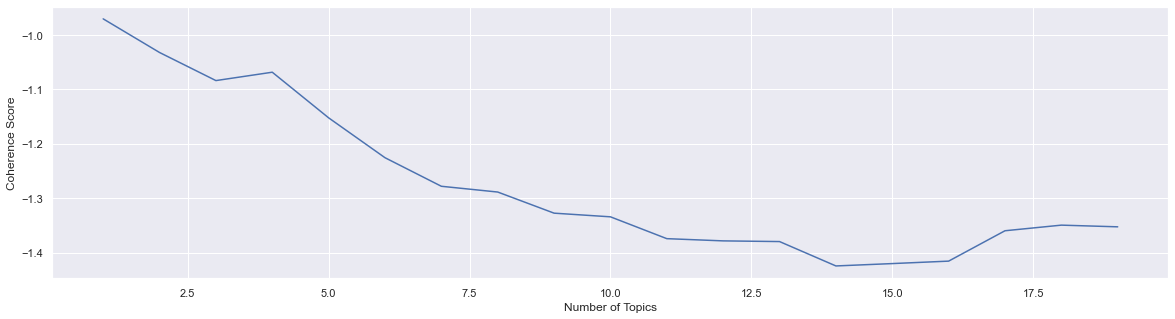

In [135]:
topics = []
score = []
for i in range(1, 20, 1):
   lda_model = LdaMulticore(corpus =corpus, id2word =dictionary, iterations =10, num_topics =i, workers =4, passes =10, random_state =100)
   cm = CoherenceModel(model =lda_model, corpus =corpus, dictionary =dictionary, coherence = 'u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_ = plt.plot(topics, score)
_ = plt.xlabel('Number of Topics')
_ = plt.ylabel('Coherence Score')
plt.show()


In [136]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/bastienll/Anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bastienll/Anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bastienll/Anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bastienll/Anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/bastienll/Anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: 

/home/bastienll/Anaconda3/lib/python3.9/site-packages/flask/json/__init__.py:211: DeprecationWarning:

Importing 'itsdangerous.json' is deprecated and will be removed in ItsDangerous 2.1. Use Python's 'json' module instead.

